# Предсказание тарифа для клиентов оператора мобильной связи

Наш заказчик хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Построим модель с максимально большим значением *accuracy*.

In [1]:
# Импортируем основные библиотеки для работы
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Импортируем модели и функции
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tqdm import tqdm

warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

## Откроем и изучим файл

Откроем файл и сохраним в переменной df, получим основную информацию с помощью метода .info() и построим гистограммы для всех признаков датасета.

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


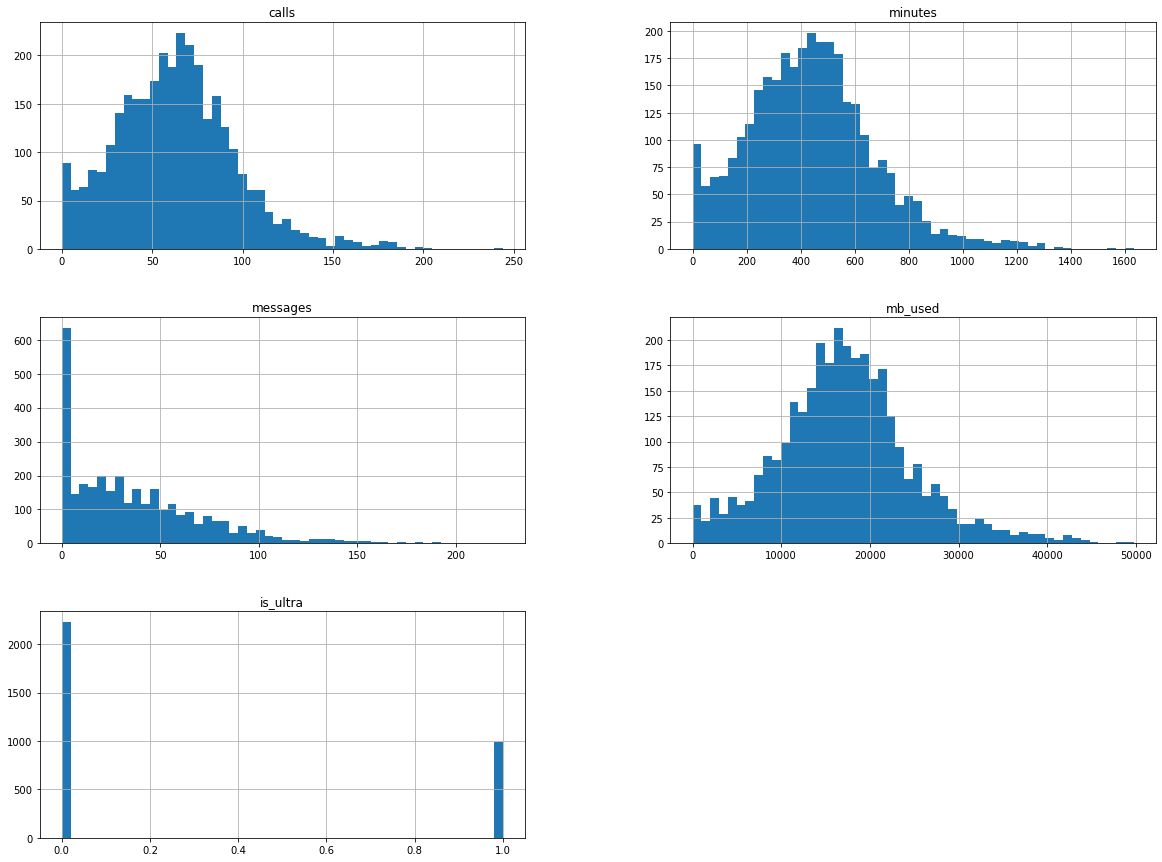

In [4]:
df.hist(figsize=(20, 15), bins=50)
plt.show()

---
**Вывод:** изучив основную информацию о датасете, можно утверждать, что
- данные очищены (из условий задачи) - не имеют пропусков, дубликатов;
- признаки имеют распределение, сильно скошенное вправо - есть смысл попробовать очистить данные от выбросов и оценить их перед дальнейшей работой;
- целевой признак распределён неравномерно, а в соотношении 2:1 (около 2200 меток "0" и 1000 меток "1"), поэтому при разбиении данных необходимо будет сохранить исходное соотношение;
- данные не стандартизированы/нормализованы - в дальнейшем исправим это.

## Предобработка данных

### Удаление выбросов

При удалении выбросов мы будем использовать алгоритм Изолирующего леса, это метод обучения без учителя, приспособленный для обнаружения аномалий в многомерных данных.

Разобьём данные на признаки и целевую метку. Посмотрим исходный размер данных перед удалением выбросов.

In [5]:
features = df.drop(columns=['is_ultra'], axis=1)
target = df['is_ultra']
print(features.shape)
print(target.shape)

(3214, 4)
(3214,)


Создадим и обучим модель Изолирующего леса на наборе признаков датасета. Спрогнозируем принадлежность к выбросам в отдельный массив (`y_outliers`) и конкатенируем его с наборами признаков датасета и целевыми метками (столбец `outliers`).

In [6]:
iso = IsolationForest(n_estimators=256, max_samples='auto', random_state=1337)
y_outliers = pd.Series(iso.fit_predict(features))
features['outliers'] = y_outliers
target = pd.concat([target, y_outliers], axis=1).rename(columns={0:'outliers'})
display(features.head())
display(target.head())

calls  minutes  messages   mb_used  outliers
0   40.0   311.90      83.0  19915.42         1
1   85.0   516.75      56.0  22696.96         1
2   77.0   467.66      86.0  21060.45         1
3  106.0   745.53      81.0   8437.39        -1
4   66.0   418.74       1.0  14502.75         1

is_ultra  outliers
0         0         1
1         0         1
2         0         1
3         1        -1
4         0         1

Удалим выбросы из наборов с признаками и метками и оценим получившийся размер наборов.

In [7]:
features = features.query('outliers != -1').drop(columns=['outliers'], axis=1)
target = target.query('outliers != -1')
target = target['is_ultra']

In [8]:
print(features.shape)
print(target.shape)

(2502, 4)
(2502,)


Удалено 700 строк. Это довольно много для нашего датасета, почти 1/4 часть. Посмотрим на получившиеся распределения признаков и меток.

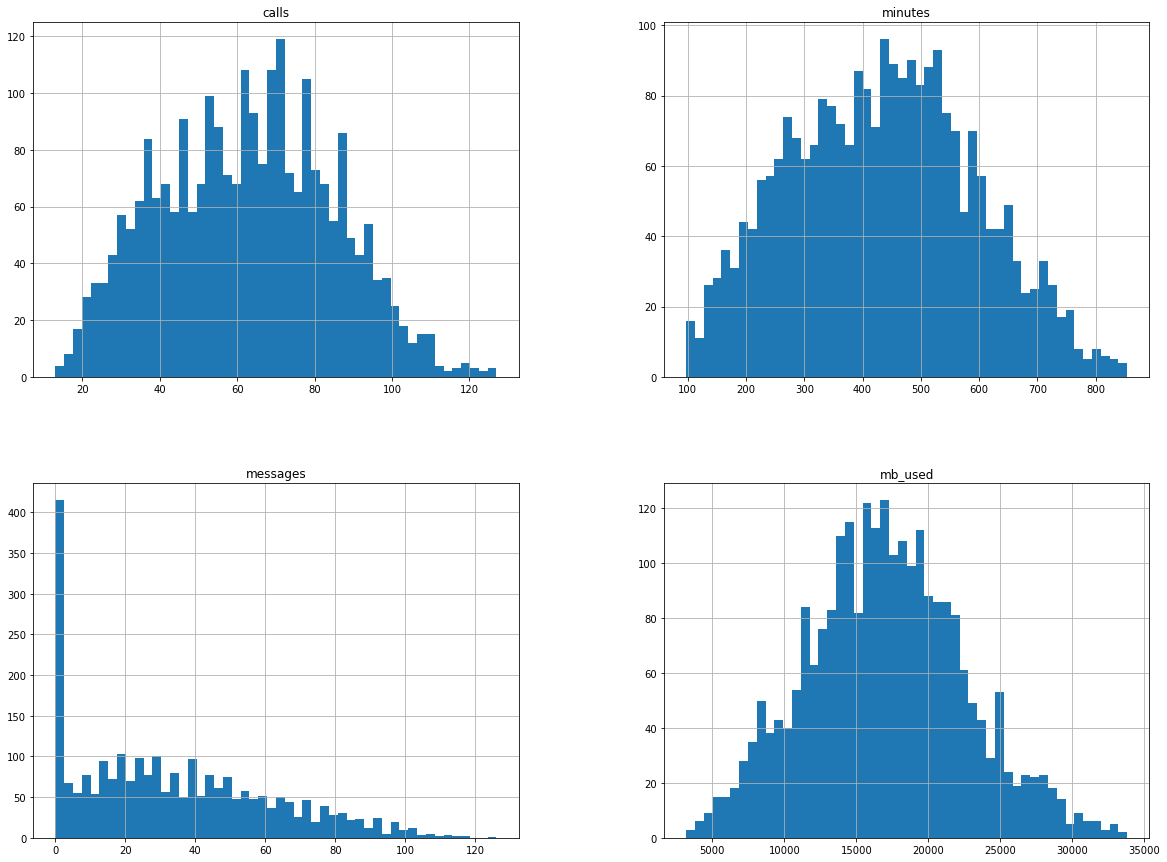

In [9]:
features.hist(figsize=(20, 15), bins=50)
plt.show()

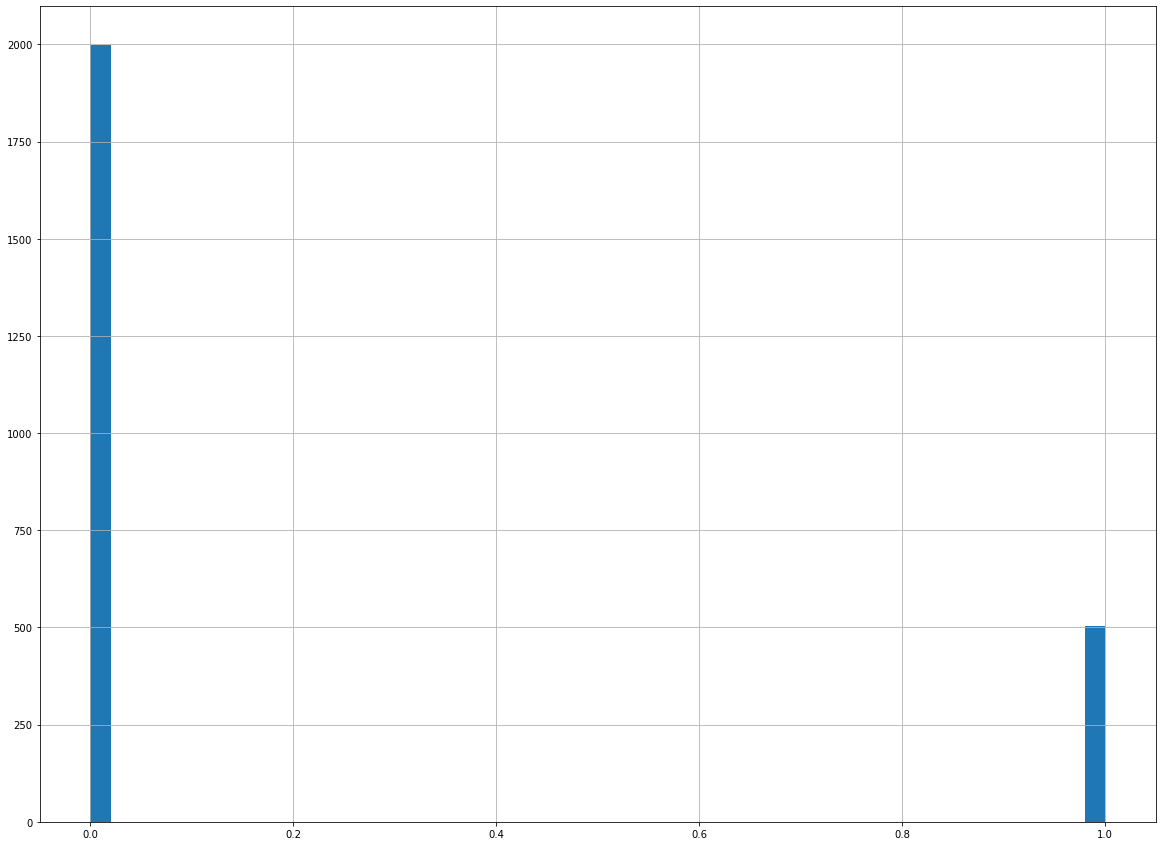

In [10]:
target.hist(figsize=(20, 15), bins=50)
plt.show()

Скошенность вправо у большинства признаков устранена, это хорошо; но нас не устраивает другое: при удалении выбросов мы потеряли 1/2 часть всех меток со значением "1" (их было 1000 у исходного набора, а стало 500). Мы не сможем эффективно обучить модели на таком получившемся наборе данных. 

Видимо, то что при первом рассмотрении похоже на выбросы, на самом деле - характер данных и их особенность.

Мы отказываемся от удаления "выбросов" и будем работать далее с исходными наборами данных.

In [11]:
features = df.drop(columns=['is_ultra'], axis=1)
target = df['is_ultra']
print(features.shape)
print(target.shape)

(3214, 4)
(3214,)


### Корреляция признаков

Проверим корреляцию признаков.

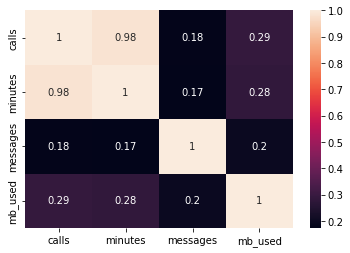

In [12]:
sns.heatmap(features.corr(), annot=True)
plt.show()

Хм, calls и minutes чрезвычайно сильно коррелируют друг с другом. Это создаёт проблему мультиколлинеарности. Может пострадать точность модели Логистической регрессии, которую мы будем исследовать чуть позже (остальные рассматриваемые модели мультиколлинеарность не затрагивает). Впрочем, если регуляризовать её по норме L2, это нивелирует проблему.

Решено, не будем устранять мультиколлинеарность:
- ни через удаление одного из сильно коррелирующих признаков;
- ни через Метод главных компонент (PCA).

---
**Вывод:** завершив этап предобработки данных, мы
- произвели удаление выбросов, но в ходе дальнейшей оценки поняли, что теряем слишком много данных и то, что нам представлялось выбросами - только характер данных; мы отказались от удаления выбросов;
- проверили данные на мультиколлинеарность, обнаружили её для двух признаков - `calls` и `minutes`; и приняли решение оставить всё как есть, т.к. она не будет оказывать влияния на точность большинства наших моделей.

## Разбиение данных на выборки

### Разбиение данных

В ходе предварительного анализа данных мы выяснили, что целевой признак распределён неравномерно, а в соотношении 2:1 (около 2200 меток "0" и 1000 меток "1"), поэтому при разбиении данных на тестовую, валидационную и обучающую выборку нам необходимо сохранить исходное соотношение.

Подготовим функцию для разбивки:

In [13]:
def data_split(features, target, train_frac, random_state=None):
    ''' 
    Использует функцию 
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    
    Параметр features: набор признаков
    Параметр target: набор целевых признаков
    Параметр train_frac: соотношение обучающего набора к исходному (от 0.0 до 1.0)

    Случайным образом разбивает исходный набор данных, но учитывает, чтобы в итоговые наборы 
    попало пропорциональное количество меток целевого признака (с помощью параметра stratify
    функции train_test_split).
    
    Соотношение размеров итоговых наборов:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Т.е.: передавая в функцию train_frac=0.6, она даёт нам 60% / 20% / 20% разбивку
    '''

    X_train, X_tmp, y_train, y_tmp = train_test_split(
                                        features,
                                        target,
                                        train_size=train_frac,
                                        random_state=random_state,
                                        stratify=target)

    X_val, X_test, y_val, y_test   = train_test_split(
                                        X_tmp,
                                        y_tmp,
                                        train_size=0.5,
                                        random_state=random_state,
                                        stratify=y_tmp)

    return X_train, X_val, X_test, y_train, y_val, y_test

Всё готово для разбивки стандартизированных данных. Произведём её в соотношении **60% на обучающую, 20% на валидационную и 20% на тестовую**.

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split(features, target, 0.6, random_state=1337)

Проверим, что в получившиеся наборы данных попало нужное нам количество строк с корректным соотношение целевых меток.

In [15]:
print(f'Общее количество меток обучающего набора: {np.unique(y_train, return_counts=True)}')
print(f'Доля меток со значением "1": {y_train.mean()}')
print('-' * 37)
print(f'Общее количество меток валидационного набора: {np.unique(y_val, return_counts=True)}')
print(f'Доля меток со значением "1": {y_val.mean()}')
print('-' * 37)
print(f'Общее количество меток тестового набора: {np.unique(y_test, return_counts=True)}')
print(f'Доля меток со значением "1": {y_test.mean()}')

Общее количество меток обучающего набора: (array([0, 1]), array([1337,  591]))
Доля меток со значением "1": 0.3065352697095436
-------------------------------------
Общее количество меток валидационного набора: (array([0, 1]), array([446, 197]))
Доля меток со значением "1": 0.30637636080870917
-------------------------------------
Общее количество меток тестового набора: (array([0, 1]), array([446, 197]))
Доля меток со значением "1": 0.30637636080870917


Отлично, всё правильно.

### Стандартизация данных

Имеет смысл произвести стандартизацию данных для масштабирования признаков (для адаптации признаков с разными диапазонами значений к моделям, использующих дистанции для прогнозирования).

Стандартизируем данные, при этом обучать Scaler мы будем только на обучающих данных, а трансформировать обучающие, валидационные и тестовые данные будем уже независимо друг от друга.

In [16]:
s_scaler = StandardScaler()
s_scaler.fit(X_train)

X_train = s_scaler.transform(X_train)
X_val = s_scaler.transform(X_val)
X_test = s_scaler.transform(X_test)

# При .transform() теряются имена столбцов, восстановим их
col_names = list(features.columns) 
X_train = pd.DataFrame(X_train, columns=col_names)
X_val = pd.DataFrame(X_val, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

Посмотрим на распределения стандартизированных данных.

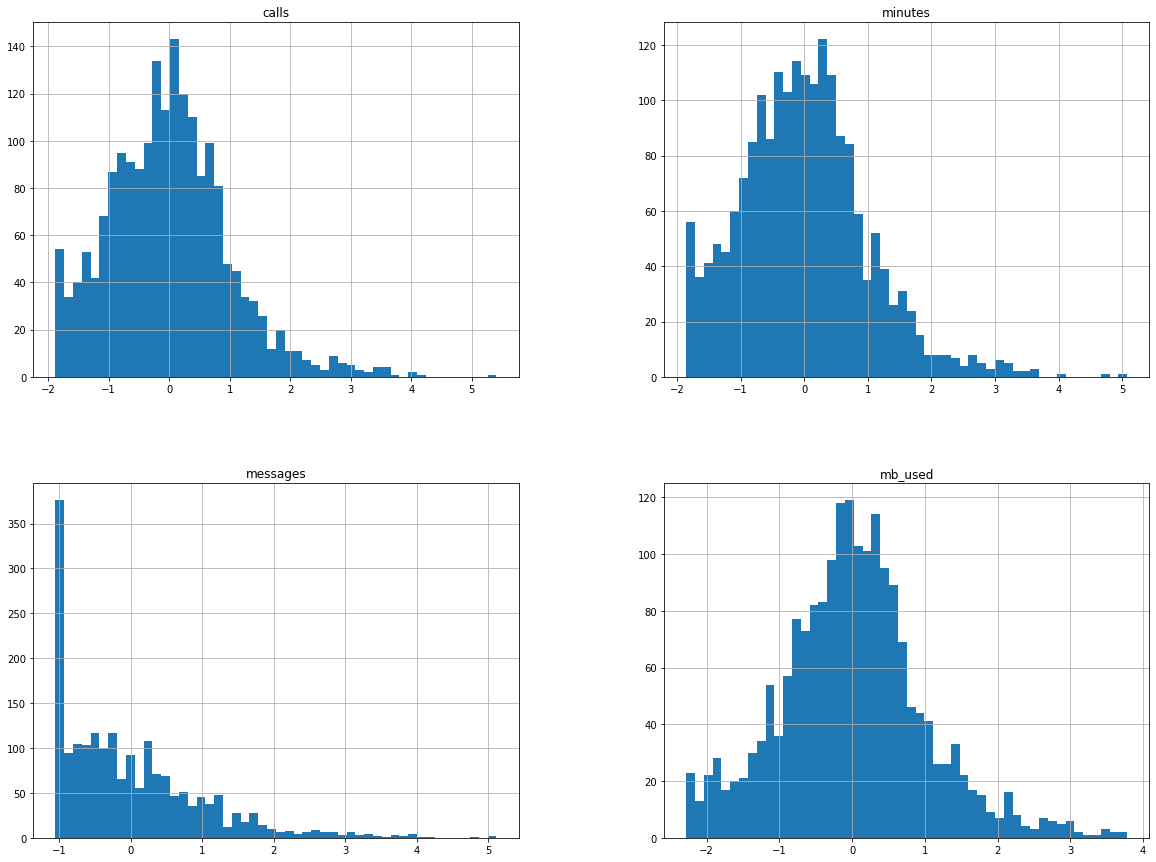

In [17]:
X_train.hist(figsize=(20, 15), bins=50)
plt.show()

Отлично, то что нужно.

---
**Вывод:** 
- мы произвели разбивку данных в соотношении 60%-20%-20% на обучающую-валидационную-тестовую выборку; в ходе разбивки мы сохранили исходное соотношение целевых меток в выборках;
- мы осуществили стандартизацию данных, предупреждая утечку данных (обучили StandardScaler только на обучающей выборке и затем трансформировали все выборки по отдельности)

## Исследование моделей

Пора исследовать модели! Мы будем оценивать следующие:
- Дерево решений;
- Случайный лес;
- Логистическая регрессия;
- Градиентный бустинг CatBoost;
- Метод опорных векторов;
- Метод К ближайших соседей;
- Многослойный перцептрон.

Приступим.

### Дерево решений

Начнём с дерева решений. Мы будем исследовать следующие гиперпараметры:
- глубина дерева (от 1 до 10);
- критерий прироста информации (индекс джини или энтропии).

Обучим модель и переберём разные значения гиперпараметров в цикле.
При исследовании модели в лог будут выводиться графики с точностью моделей.

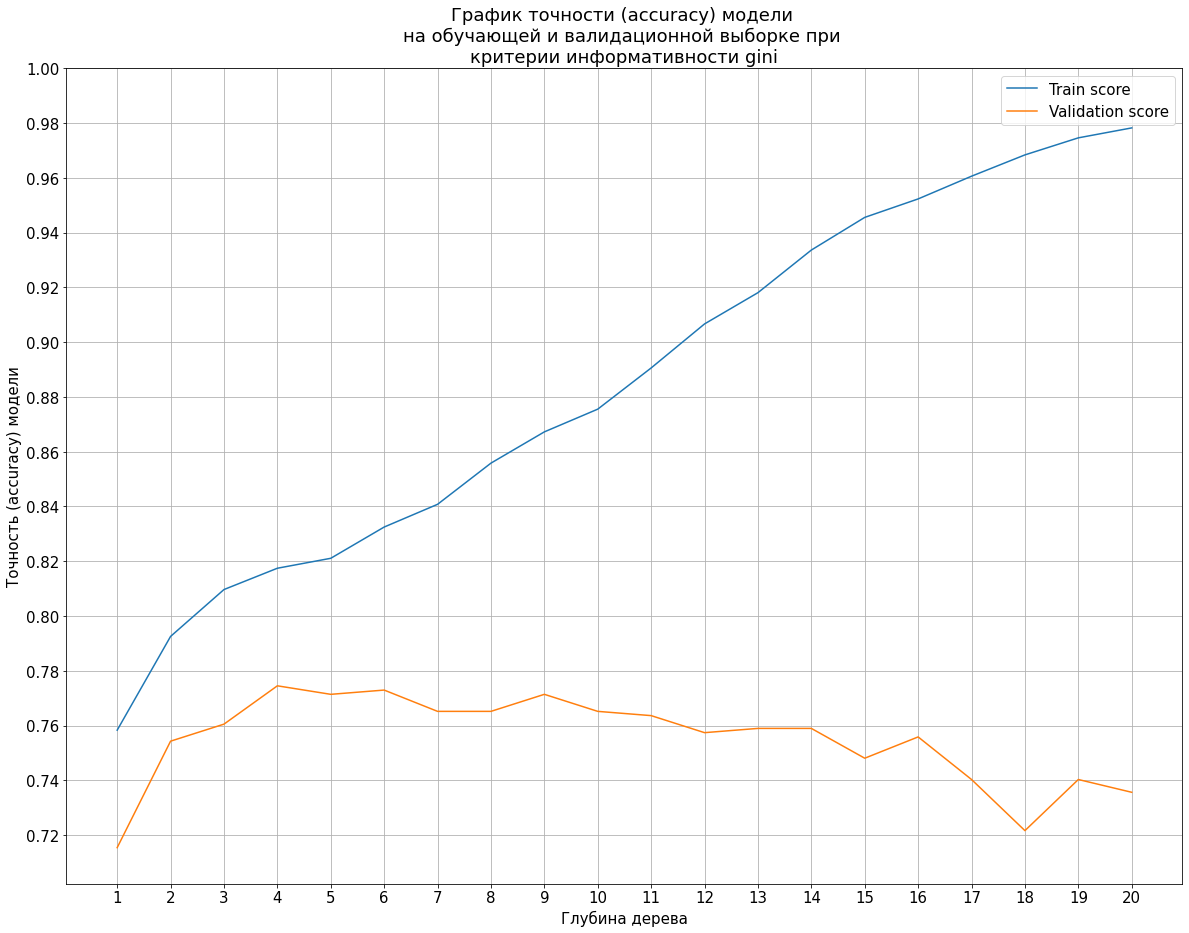

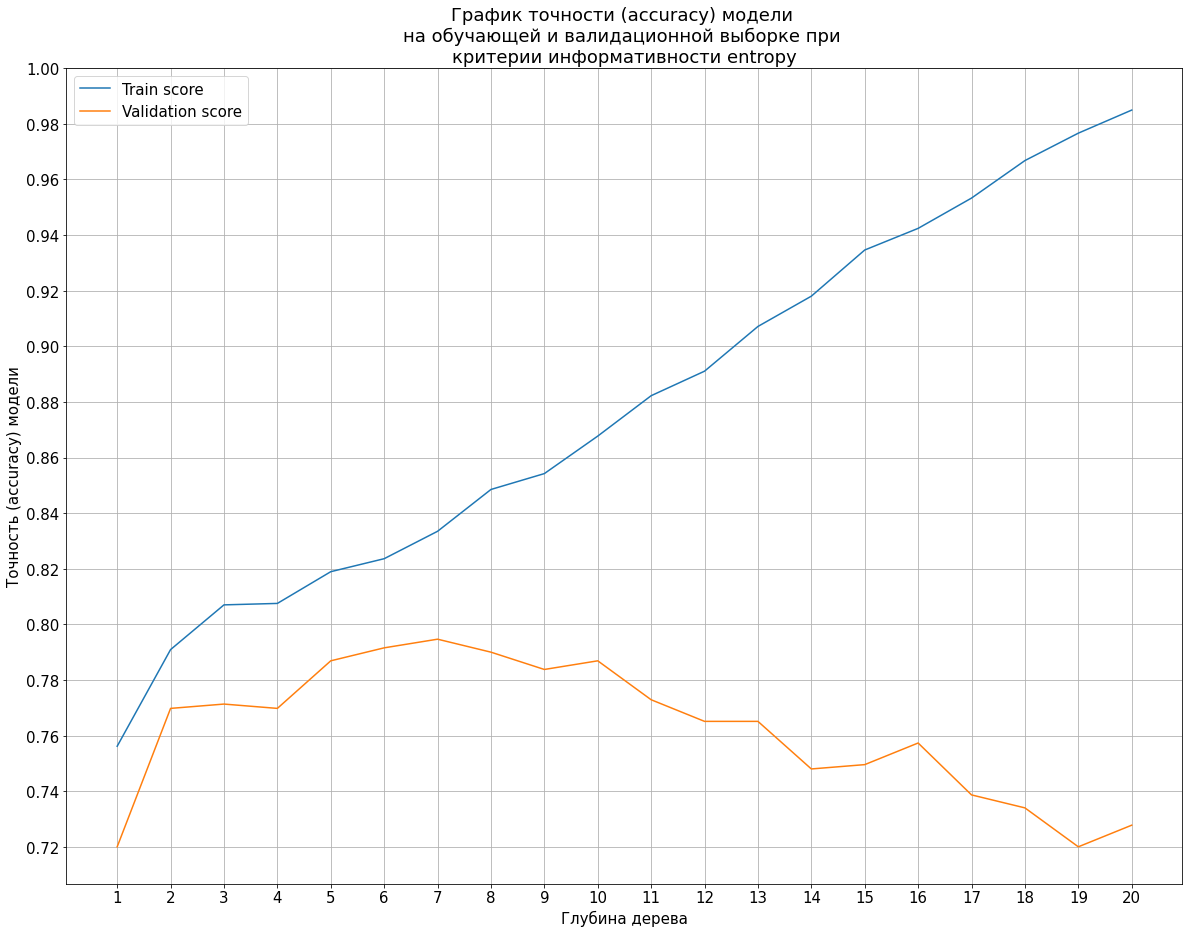

In [18]:
best_dtc = None
best_depth = 0
best_score = 0
best_criterion = None

for criterion in ['gini', 'entropy']:
    train_score_plt = []
    val_score_plt = []
    depth_plt = []
    
    for depth in range(1, 21):
        dtc = DecisionTreeClassifier(random_state=1337, max_depth=depth, criterion=criterion)
        dtc.fit(X_train, y_train)
        score = dtc.score(X_val, y_val)
        train_score_plt.append(dtc.score(X_train, y_train))
        val_score_plt.append(score)
        depth_plt.append(depth)
        if score > best_score:
            best_dtc = dtc
            best_score = score
            best_depth = depth
            best_criterion = criterion
            
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(20,15))
    plt.plot(depth_plt, train_score_plt, label='Train score')
    plt.plot(depth_plt, val_score_plt, label='Validation score')
    plt.xticks(range(1,21))
    plt.yticks(np.arange(round(min(val_score_plt), 2), round(max(train_score_plt)+0.02, 2), 0.02))
    plt.xlabel('Глубина дерева')
    plt.ylabel('Точность (accuracy) модели')
    plt.title(f'График точности (accuracy) модели \nна обучающей и валидационной выборке при \nкритерии информативности {criterion}')
    plt.grid(True)
    plt.legend()
    plt.show()

In [19]:
print(f'Лучшая модель дерева решений показала долю правильных ответов {best_score}.')
print(f'Глубина дерева: {best_depth}, критерий: {best_criterion}.')

Лучшая модель дерева решений показала долю правильных ответов 0.7947122861586314.
Глубина дерева: 7, критерий: entropy.


Визуализируем первые 3 уровня лучшей модели дерева - для наглядности. Надо учитывать, что т.к. мы обучали модель на стандартизированных данных, значения разбивки признаков тоже стандартизированны.

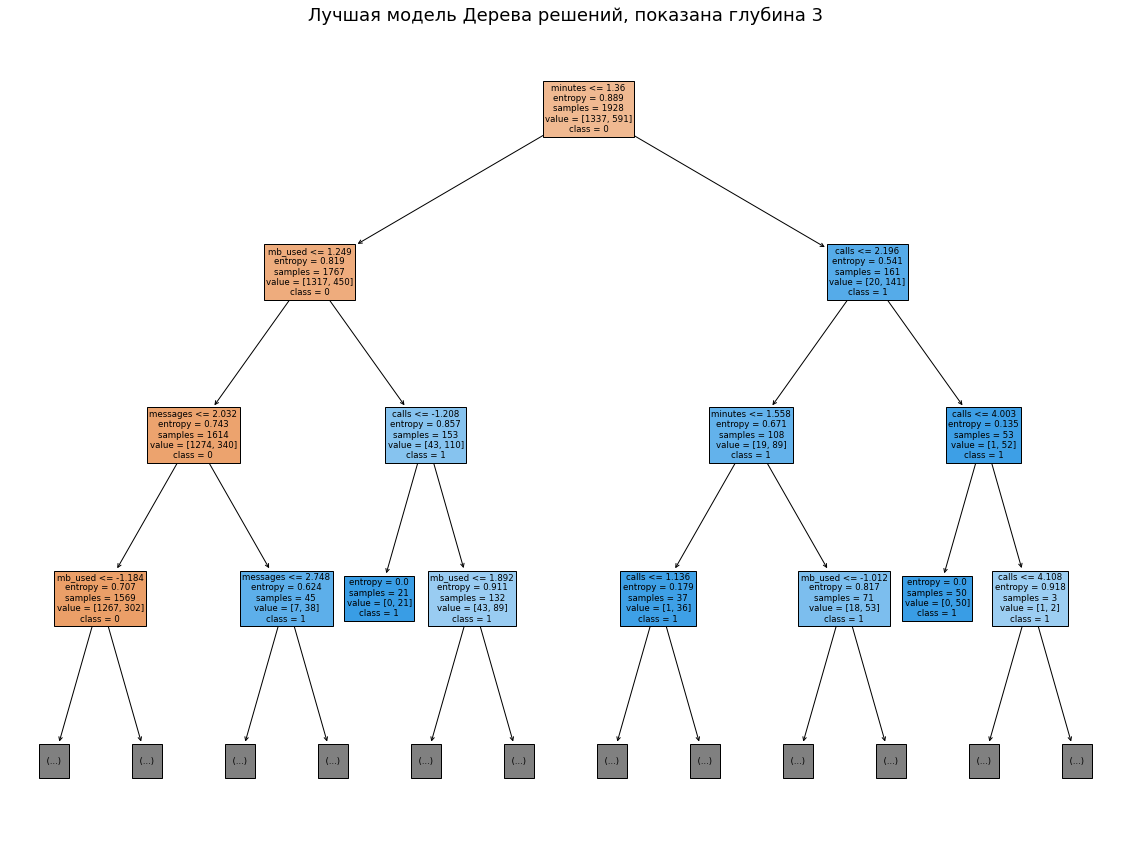

In [20]:
plt.figure(figsize=(20,15))
plot_tree(best_dtc, max_depth=3, feature_names=features.columns, label='all',class_names=['0','1'], filled=True)
plt.title("Лучшая модель Дерева решений, показана глубина 3")
plt.show()

В целом видно, что дерево идентифицирует метку "1" ("тариф ultra") так: у объектов с данной меткой существенно больше потрачено минут или использовано мегабайт или гораздо больше sms-сообщений.

Мы получили удовлетворительную долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

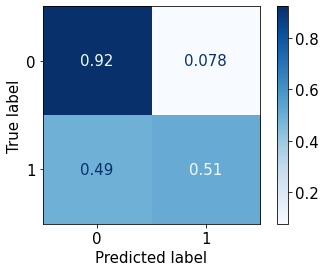

In [21]:
plot_confusion_matrix(estimator=best_dtc, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

Видно, что модель хорошо определяет истинно отрицательные значения (>90%), но истинно положительные определяет со случайной вероятностью (~50%).

### Случайный лес

Теперь в качестве модели будем использовать случайный лес. Мы будем исследовать следующие гиперпараметры:
- глубина дерева (от 5 до 15);
- количество деревьев (от 5 до 50);
- критерий прироста информации (индекс джини или энтропии).

Обучим модель и переберём разные значения гиперпараметров в цикле.
При исследовании модели в лог будут выводиться графики.

  0%|          | 0/10 [00:00<?, ?it/s]

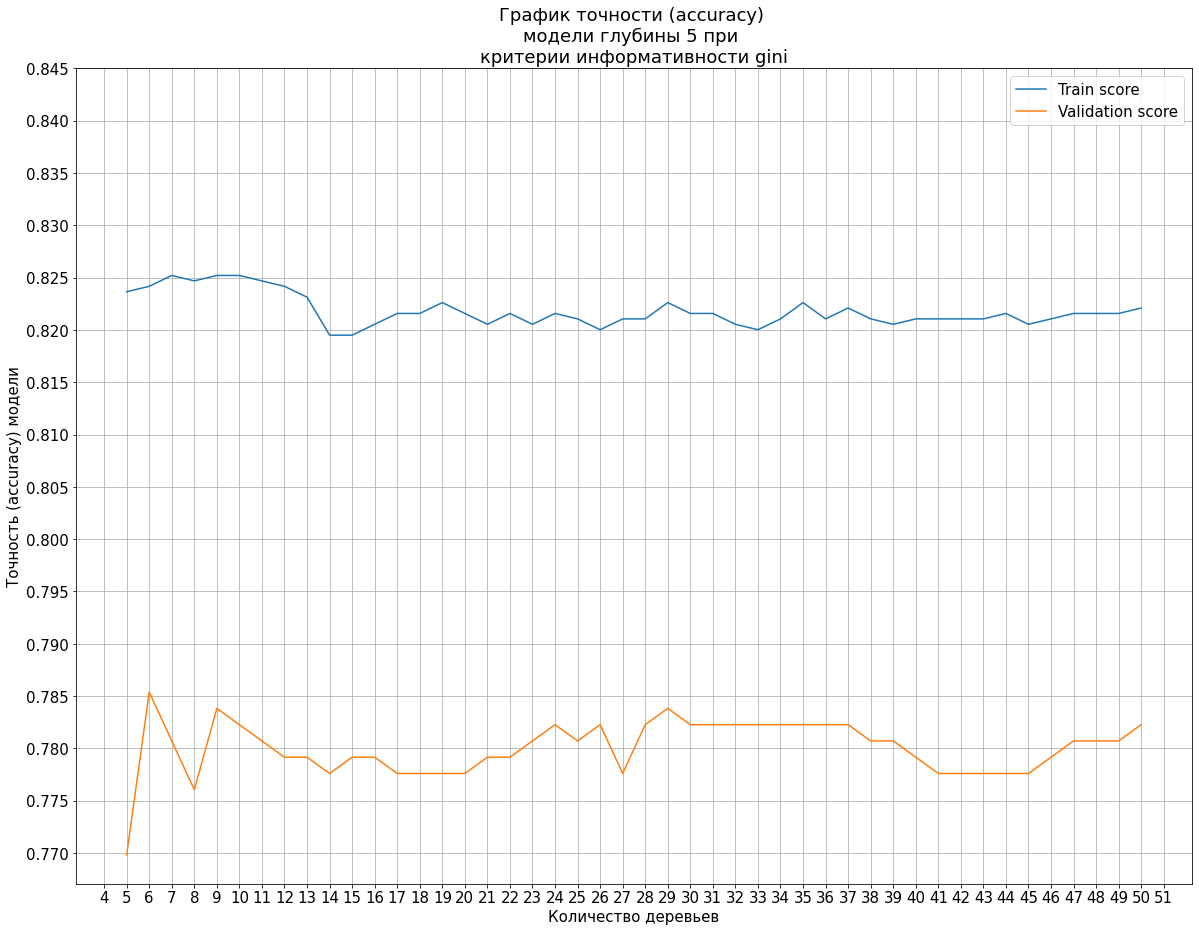

 10%|█         | 1/10 [00:02<00:22,  2.47s/it]

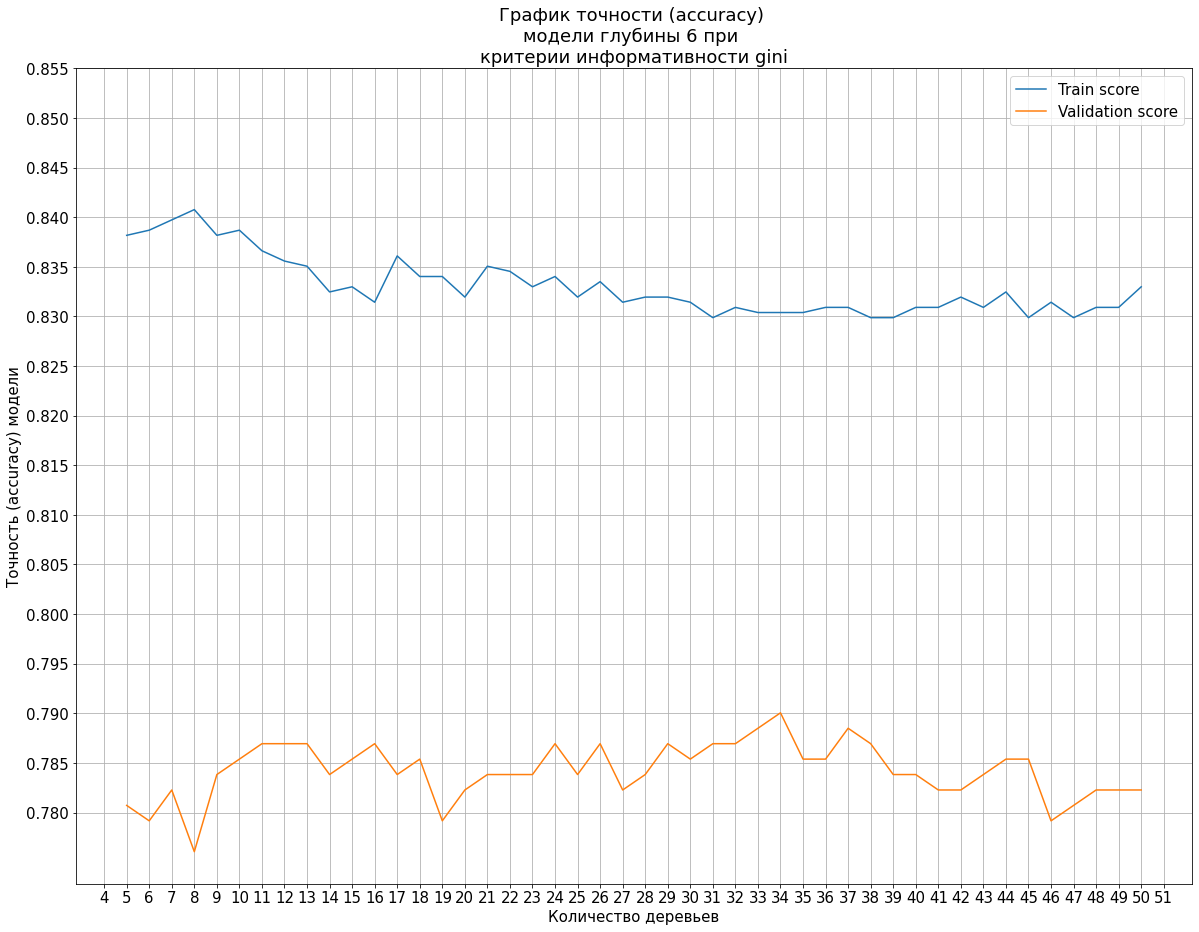

 20%|██        | 2/10 [00:05<00:20,  2.58s/it]

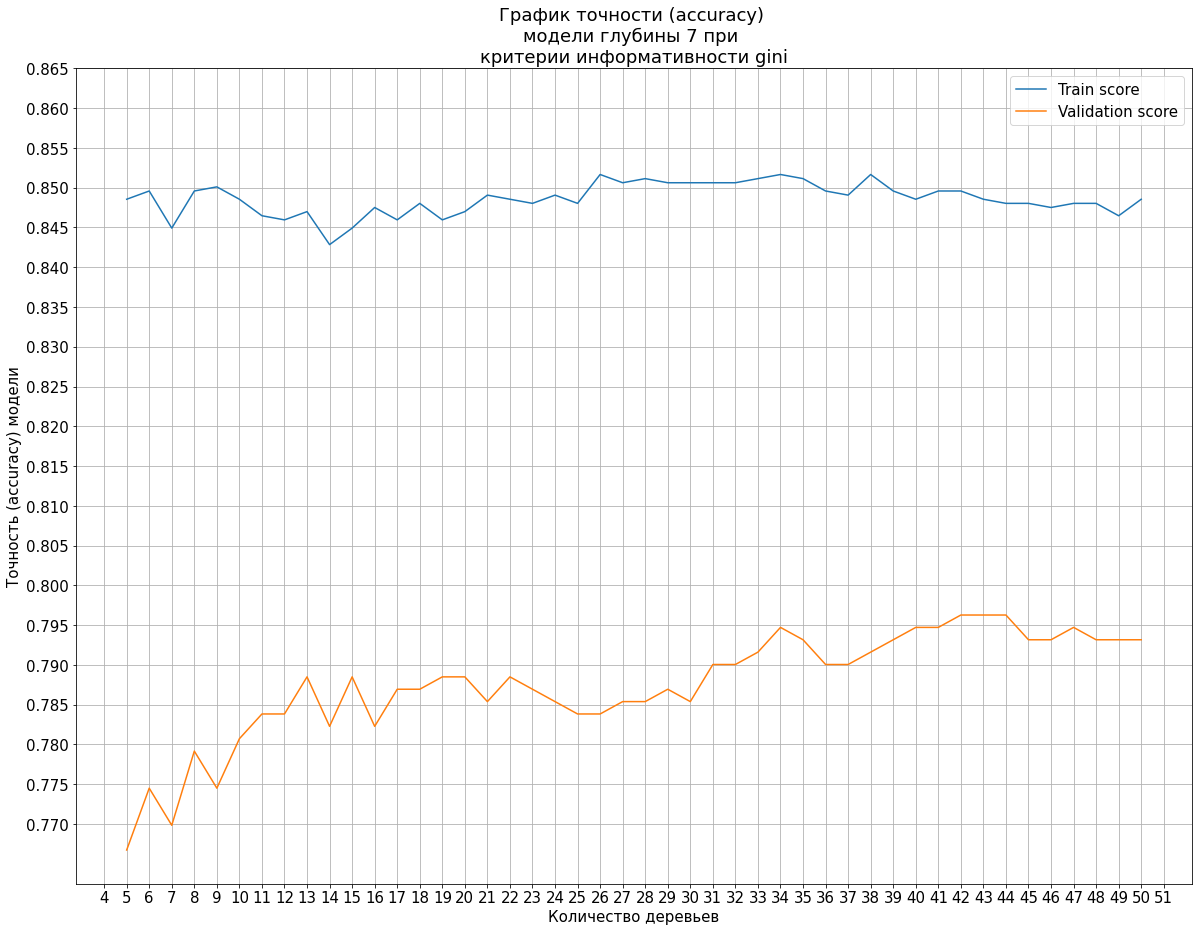

 30%|███       | 3/10 [00:08<00:19,  2.72s/it]

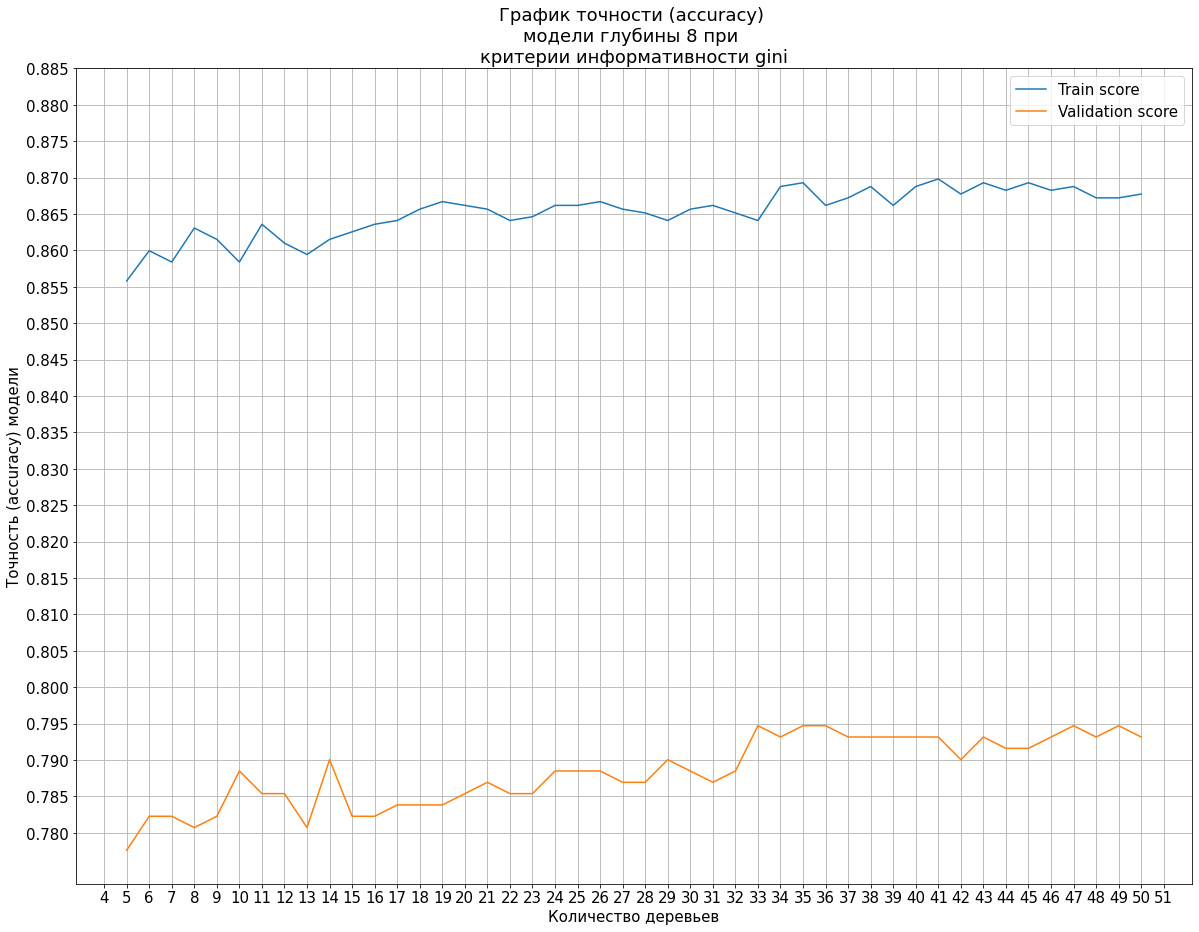

 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

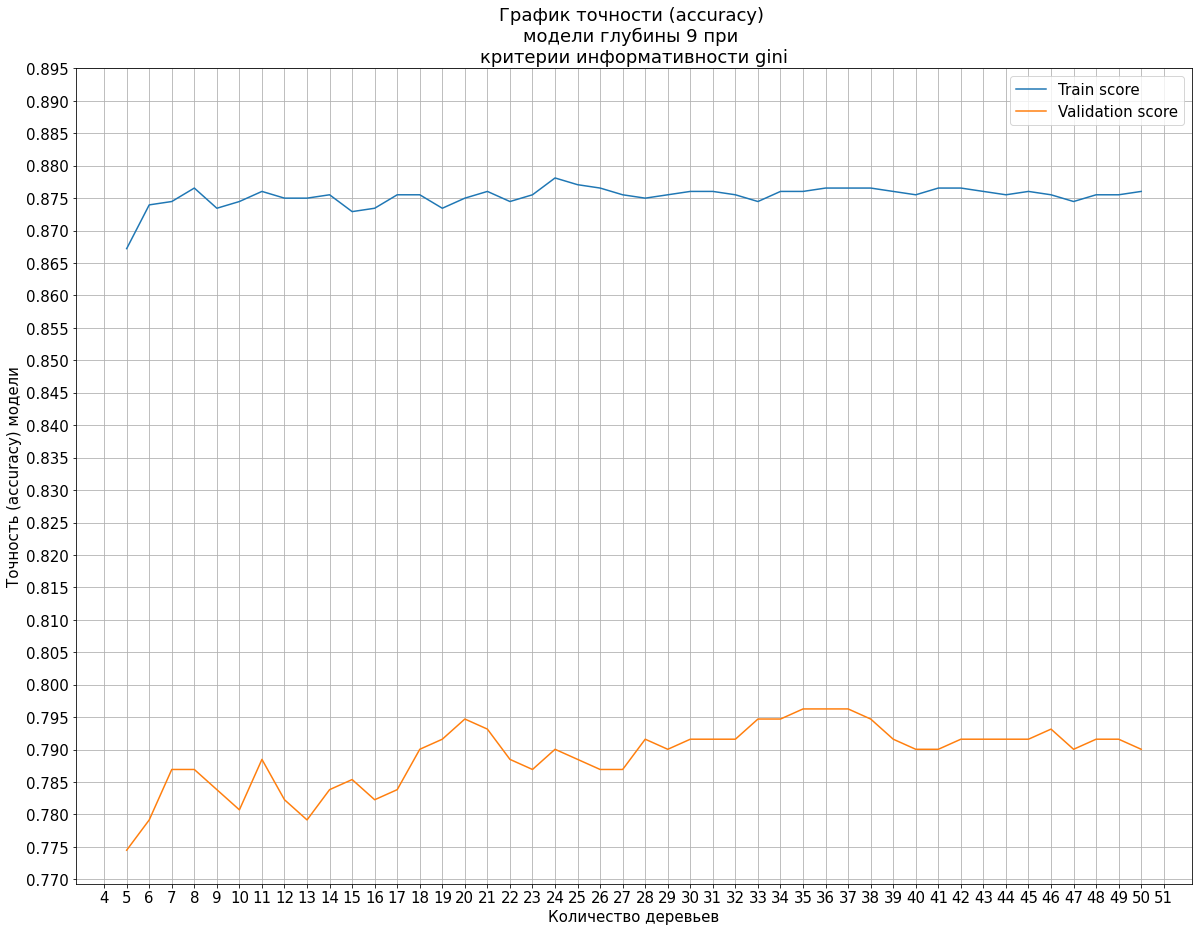

 50%|█████     | 5/10 [00:14<00:15,  3.18s/it]

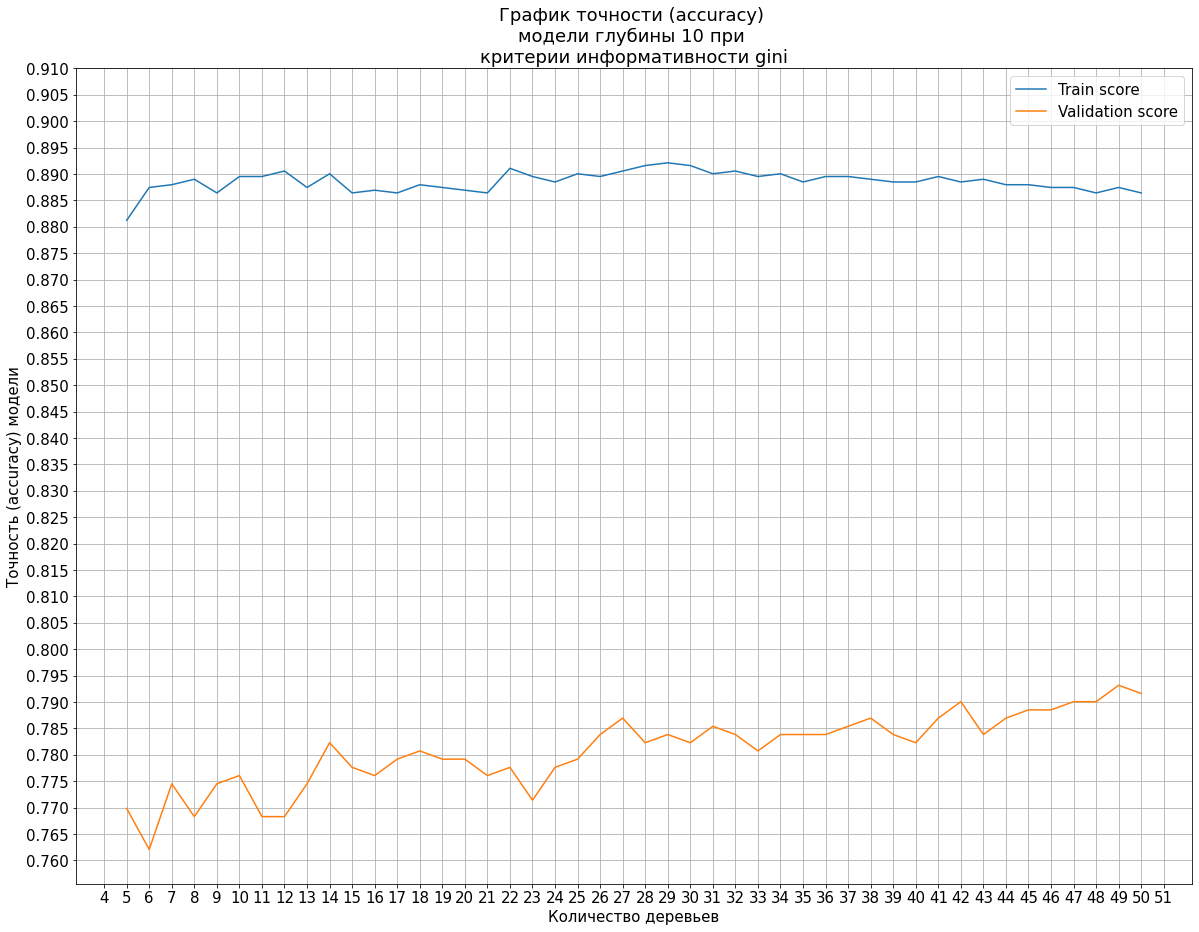

 60%|██████    | 6/10 [00:18<00:13,  3.30s/it]

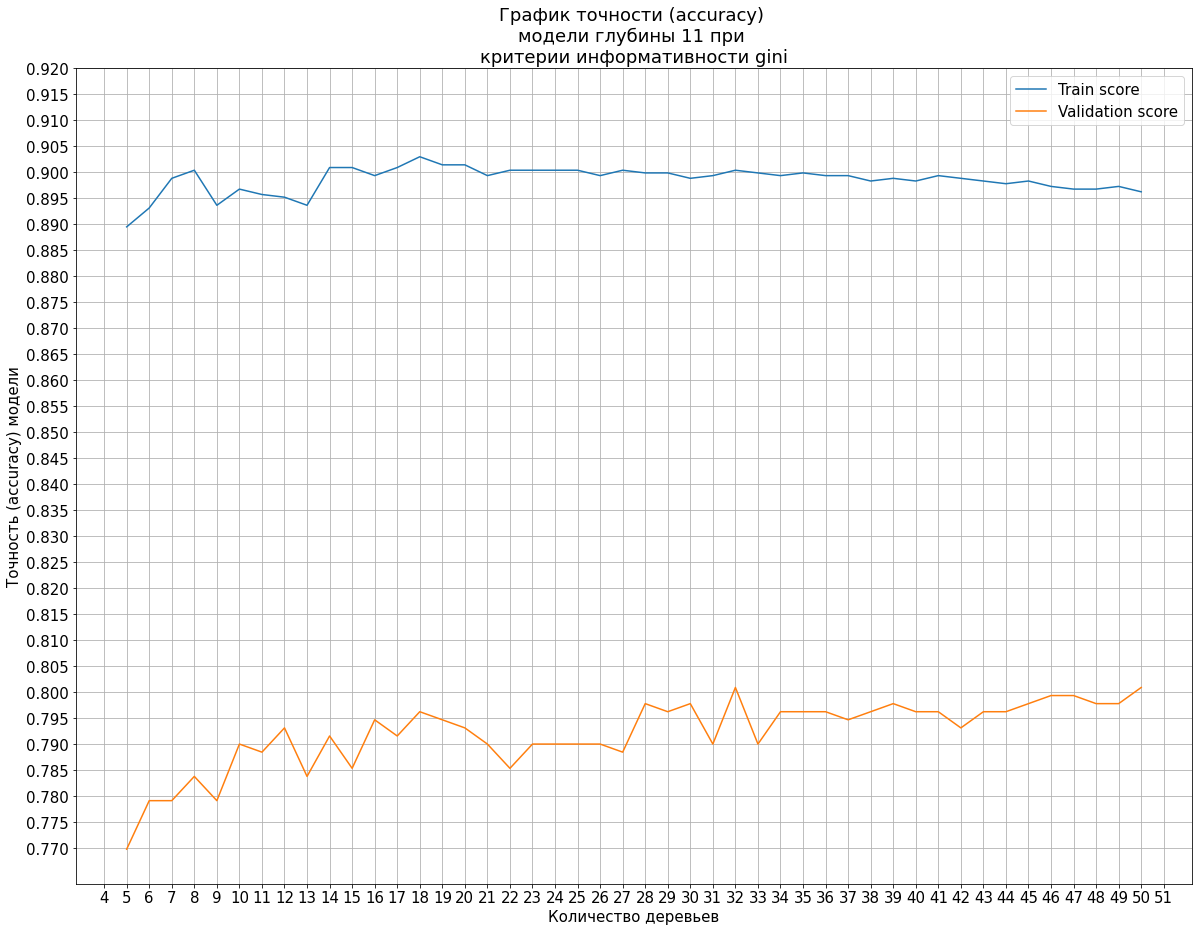

 70%|███████   | 7/10 [00:22<00:10,  3.41s/it]

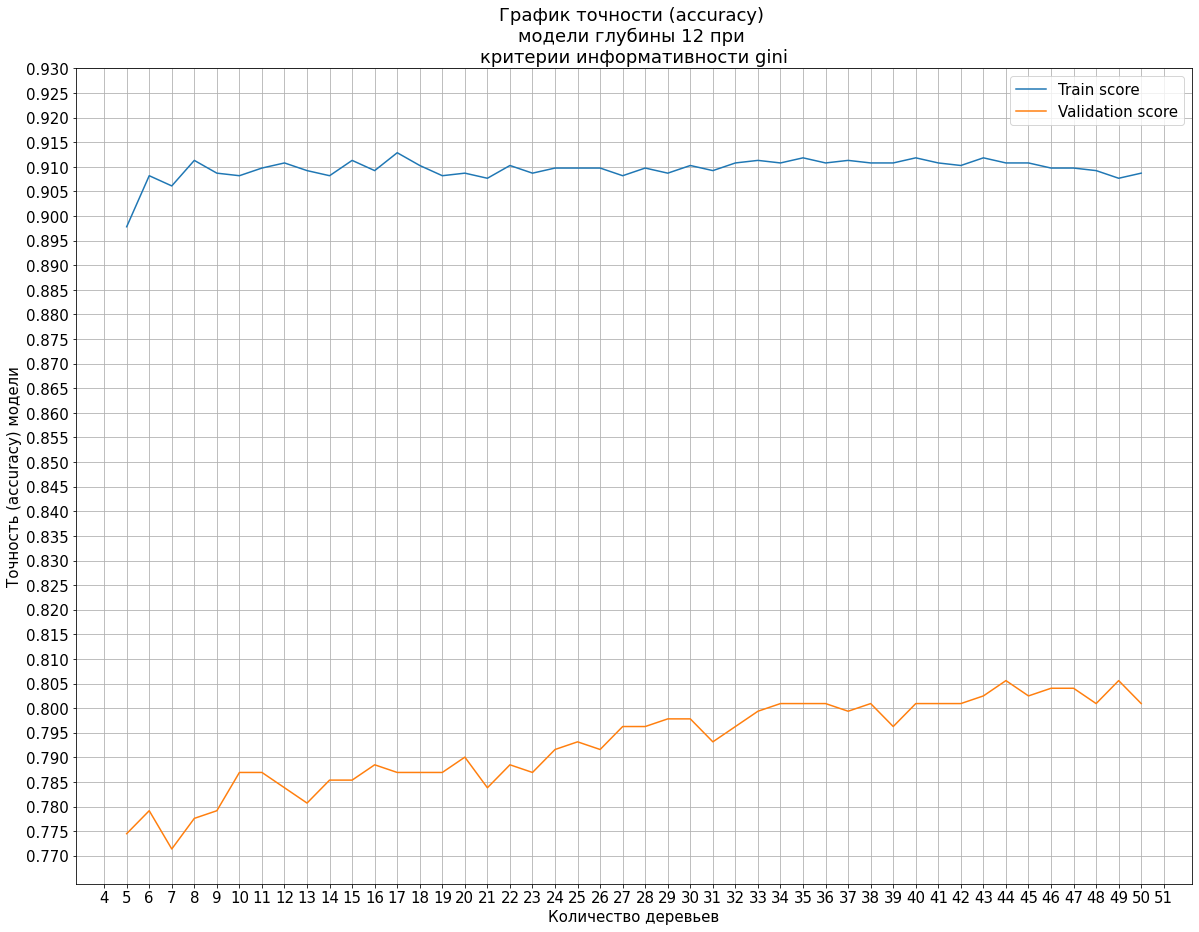

 80%|████████  | 8/10 [00:25<00:06,  3.47s/it]

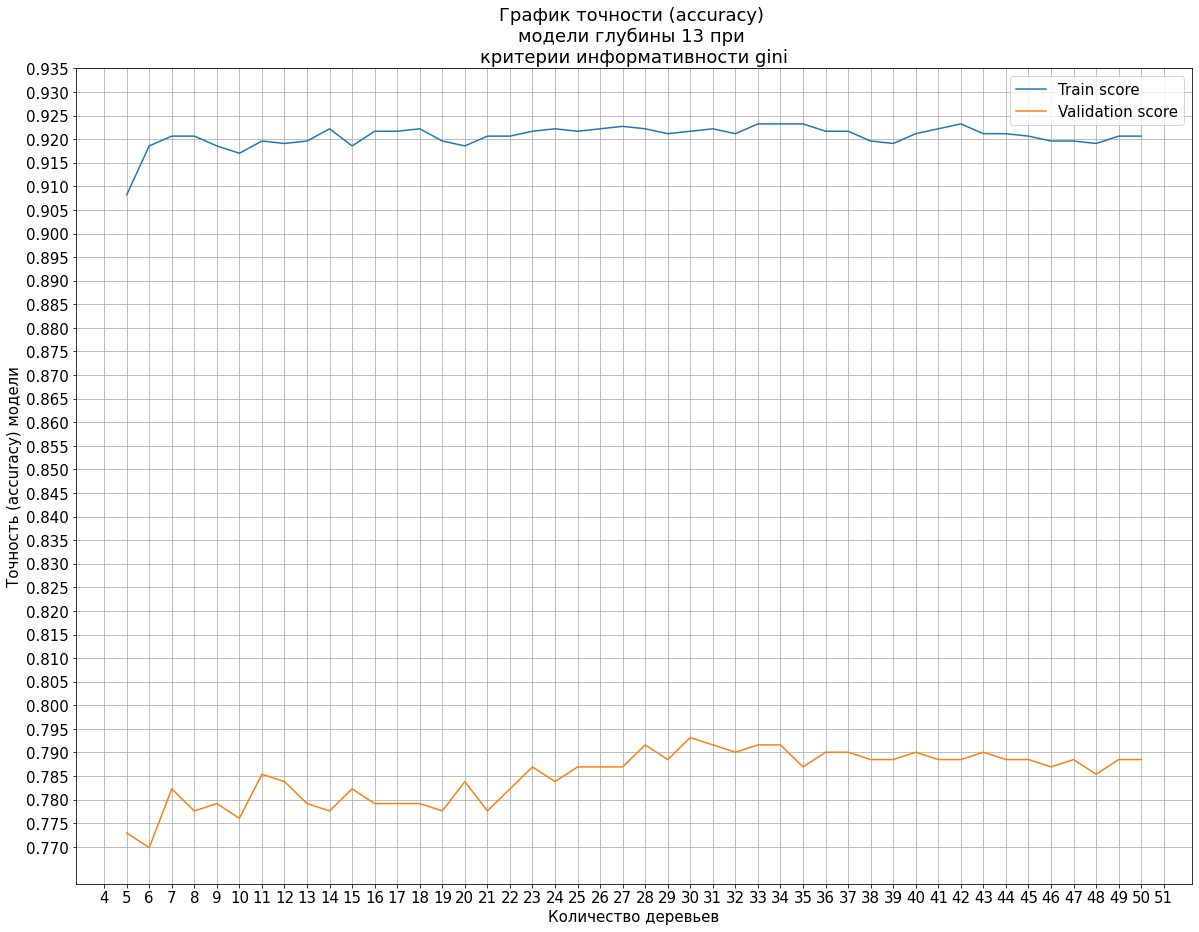

 90%|█████████ | 9/10 [00:29<00:03,  3.54s/it]

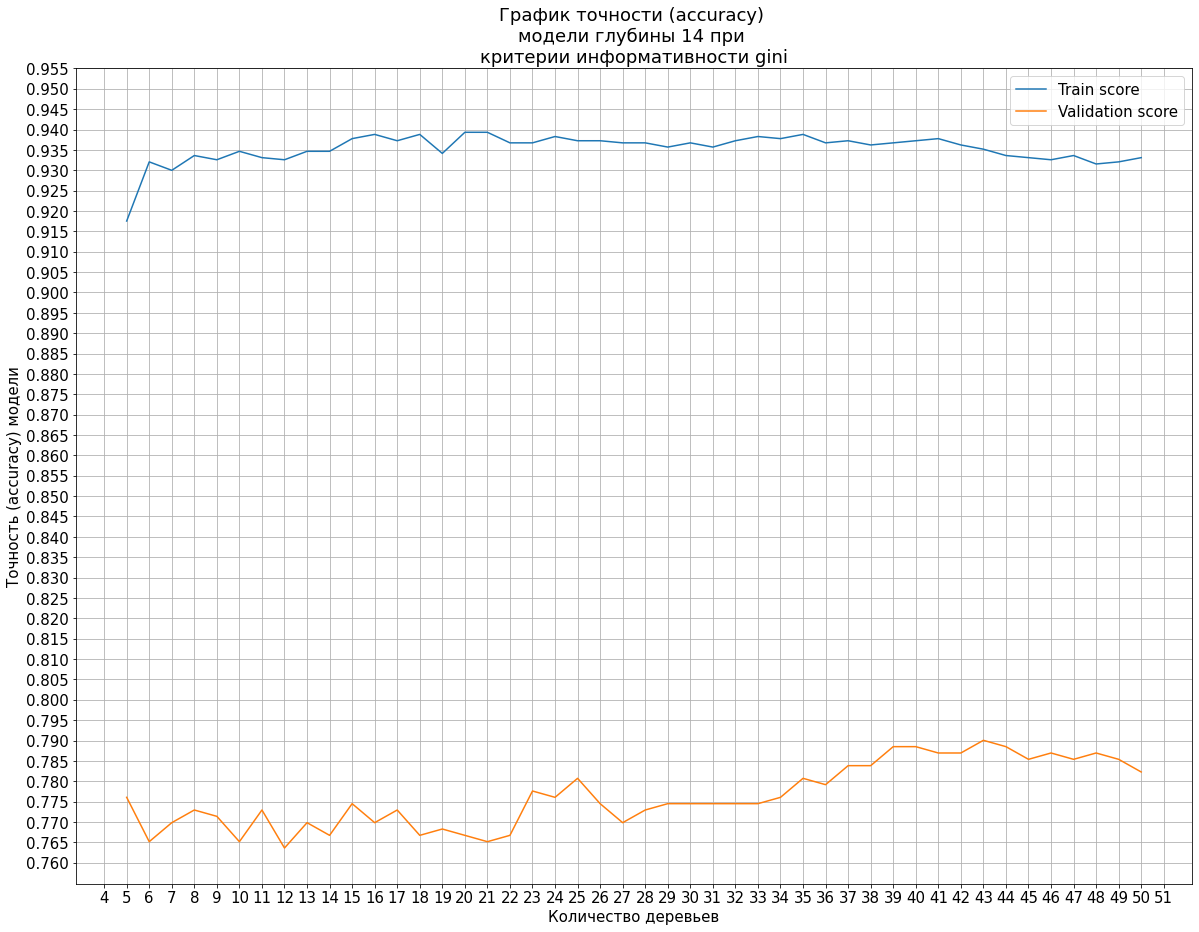

  0%|          | 0/10 [00:00<?, ?it/s]

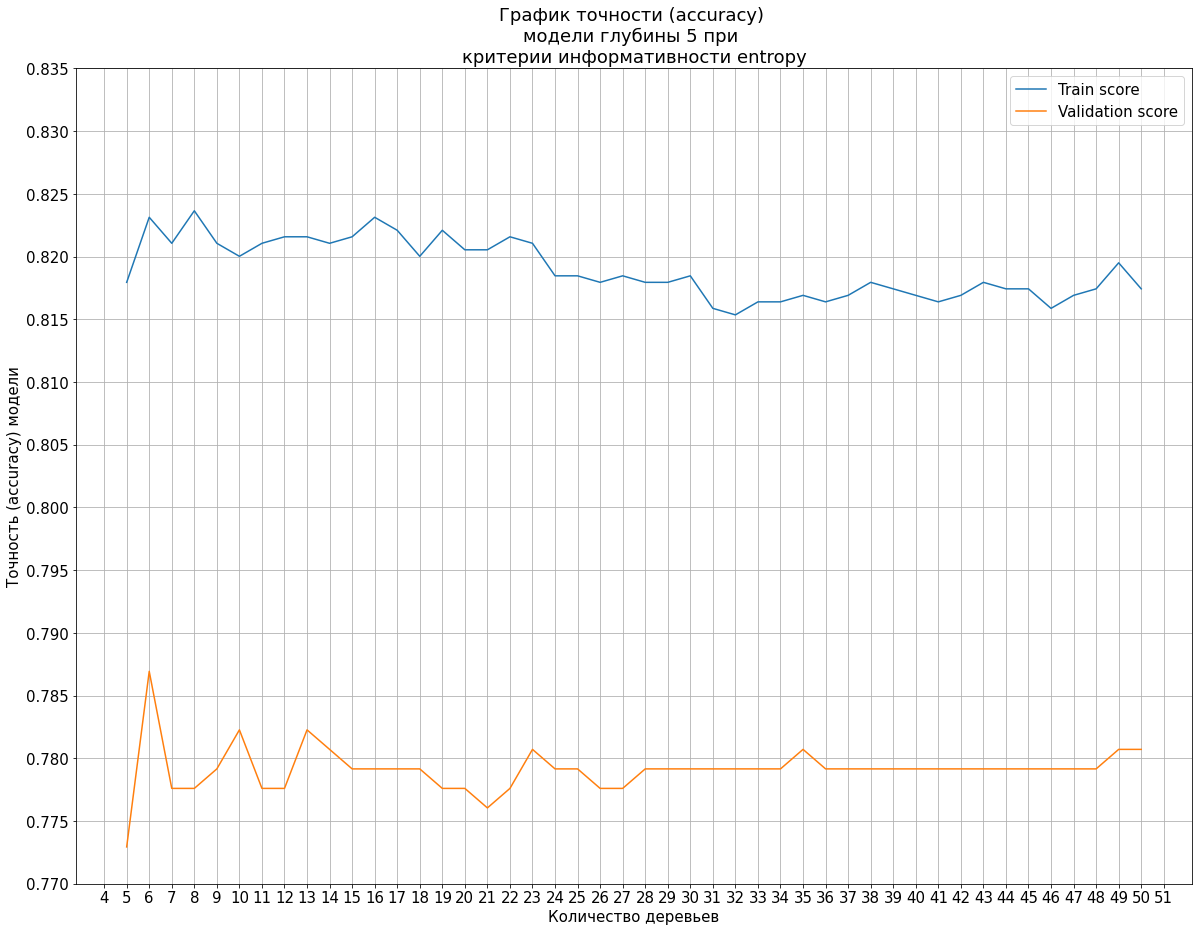

 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

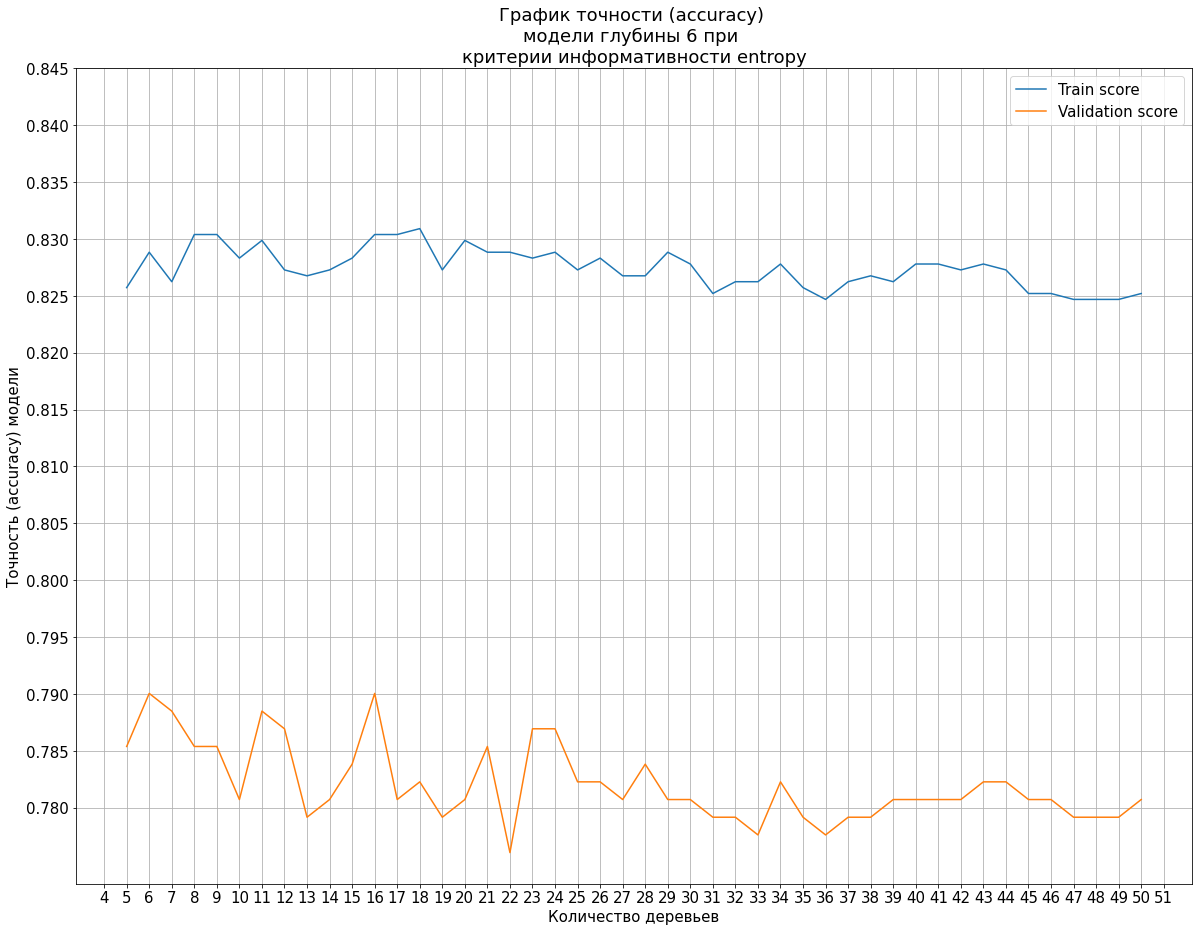

 20%|██        | 2/10 [00:05<00:24,  3.01s/it]

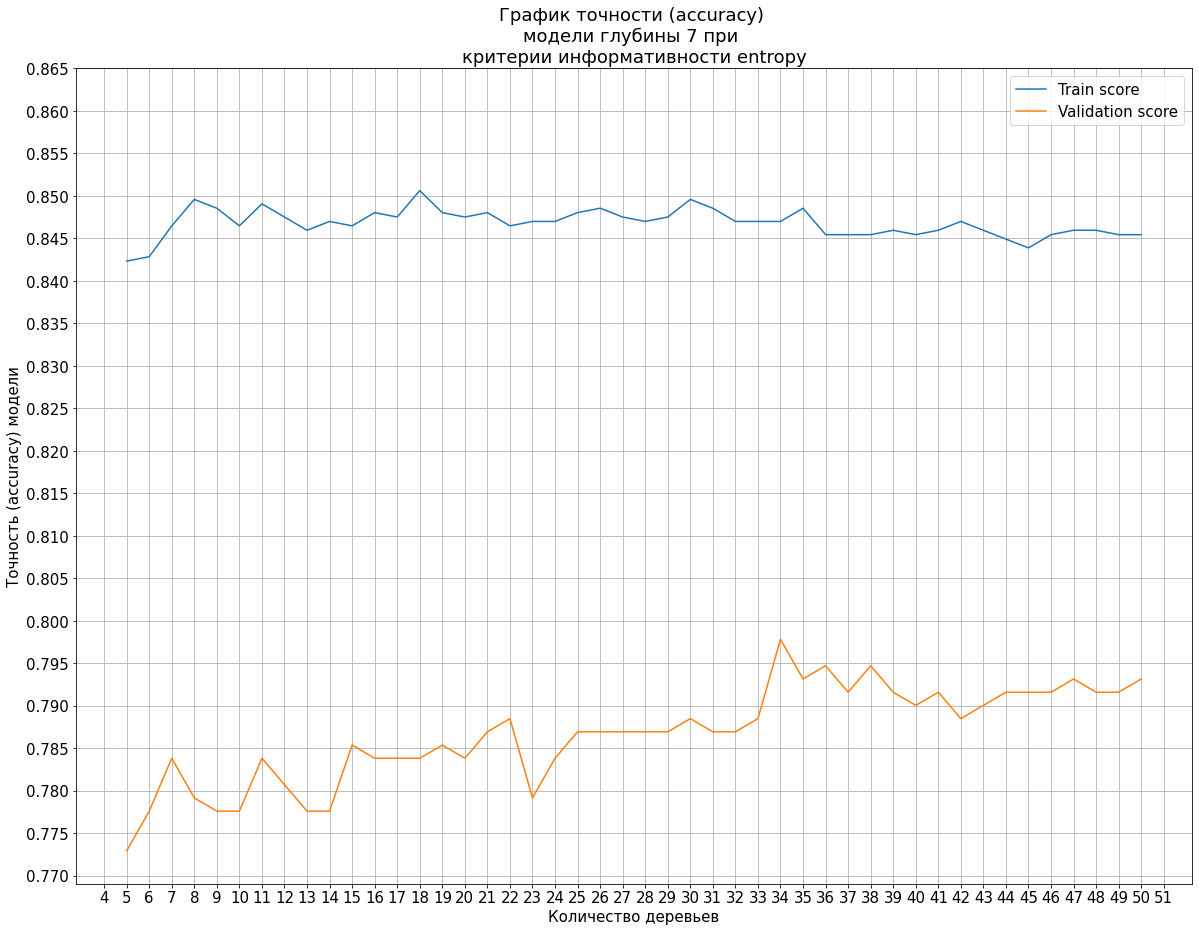

 30%|███       | 3/10 [00:09<00:22,  3.17s/it]

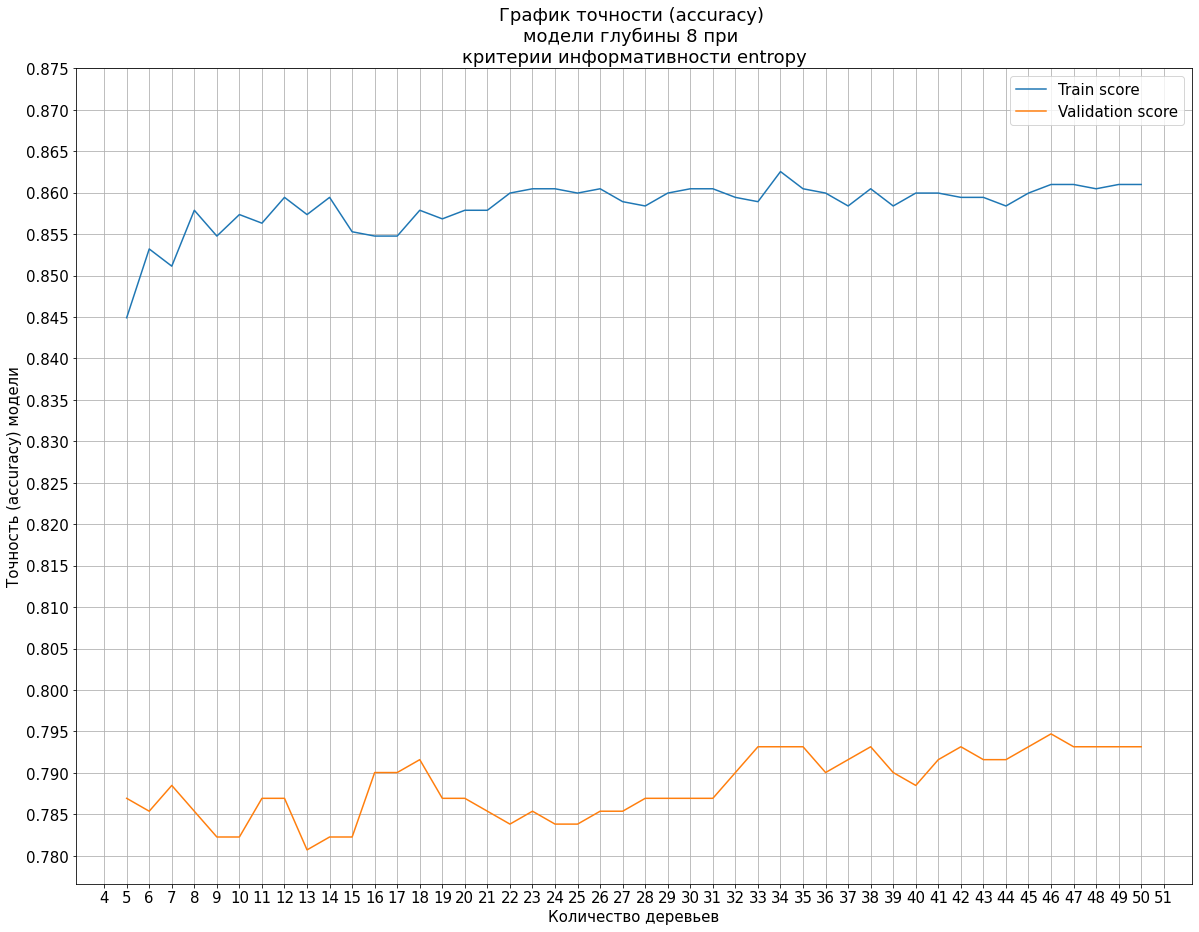

 40%|████      | 4/10 [00:12<00:19,  3.30s/it]

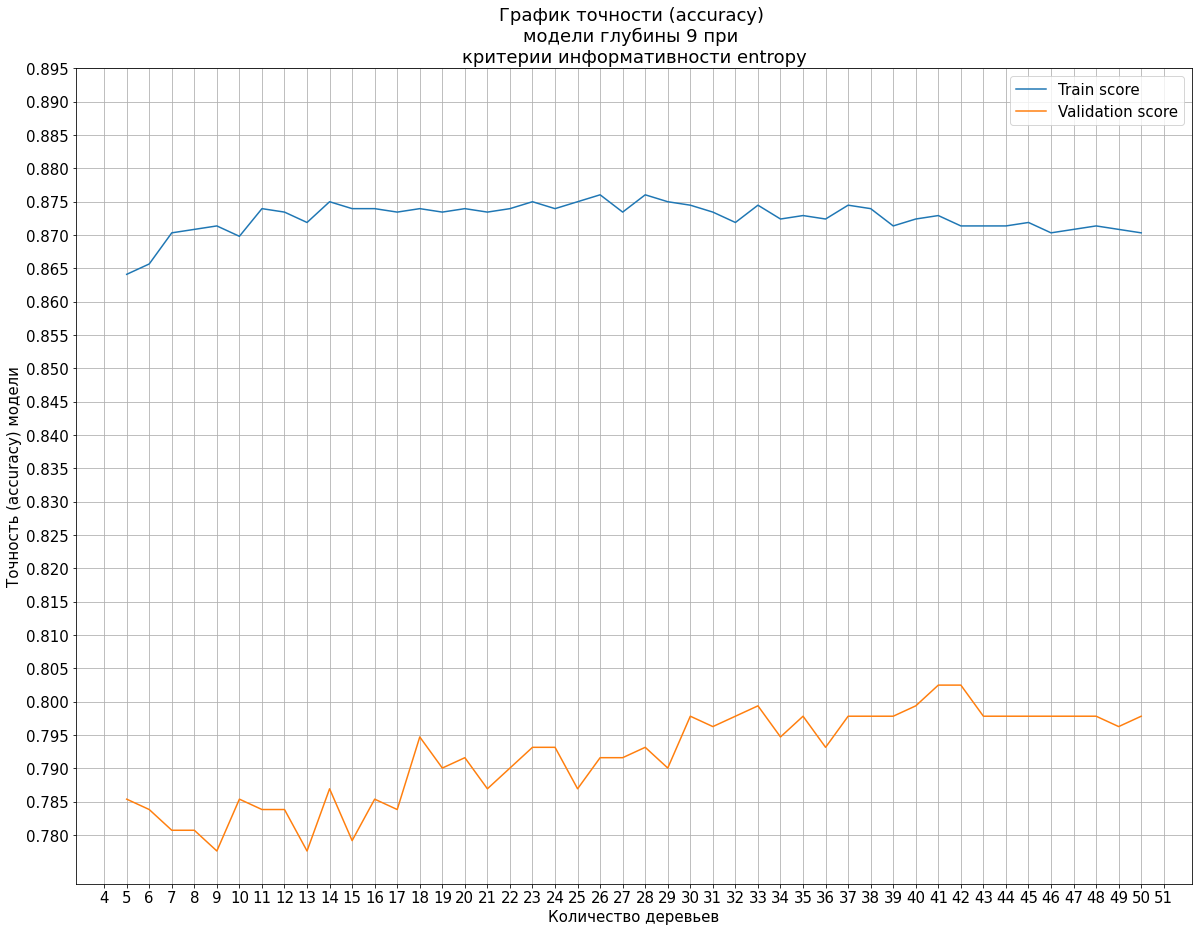

 50%|█████     | 5/10 [00:16<00:17,  3.51s/it]

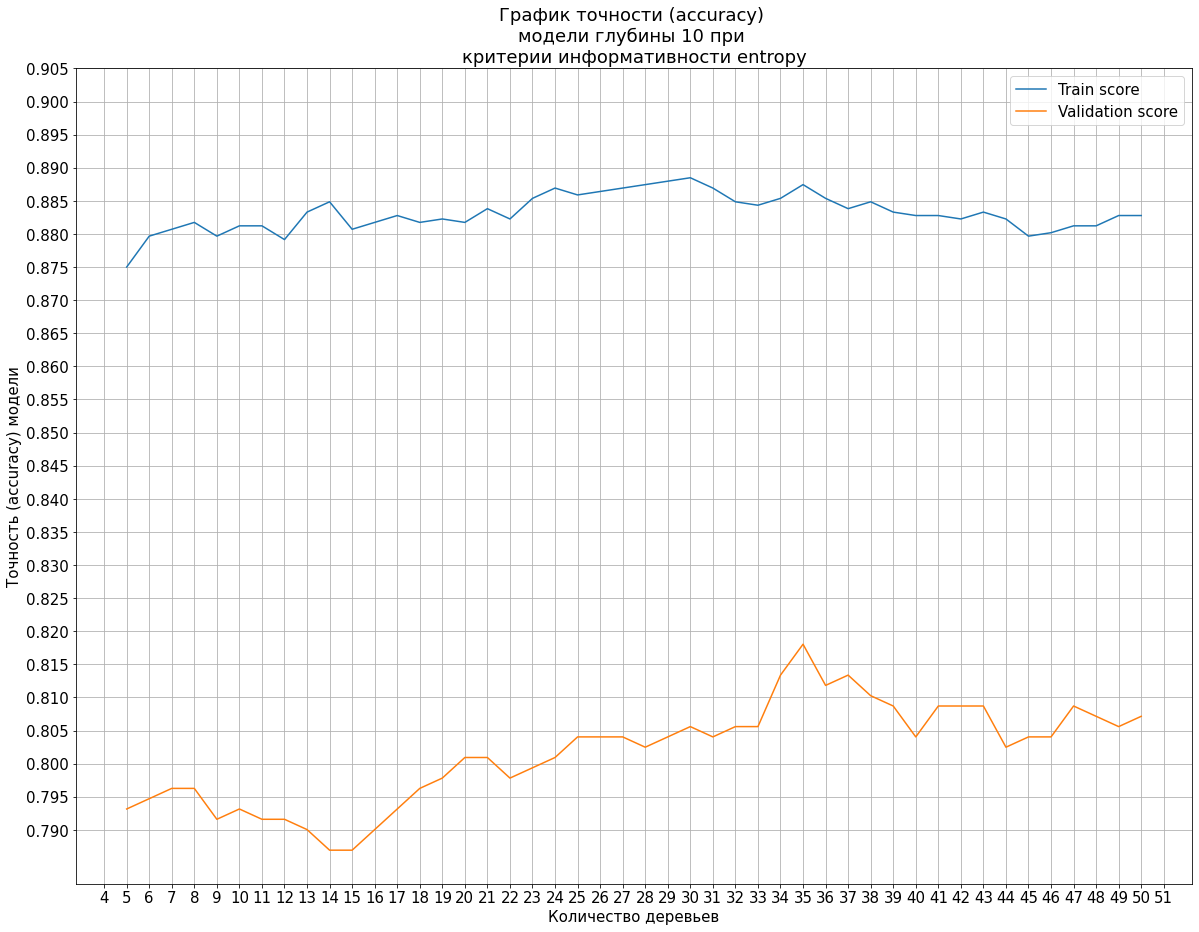

 60%|██████    | 6/10 [00:20<00:14,  3.64s/it]

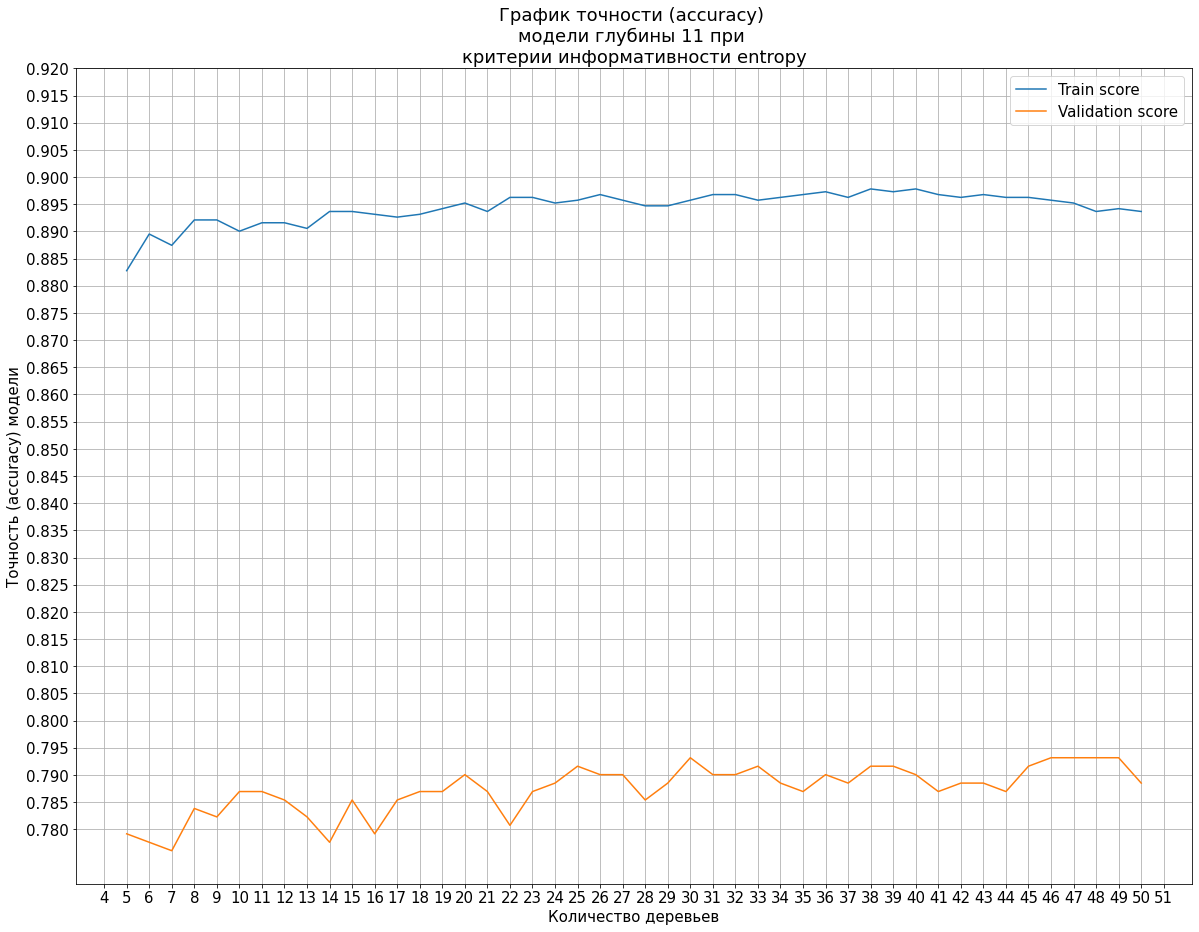

 70%|███████   | 7/10 [00:24<00:11,  3.82s/it]

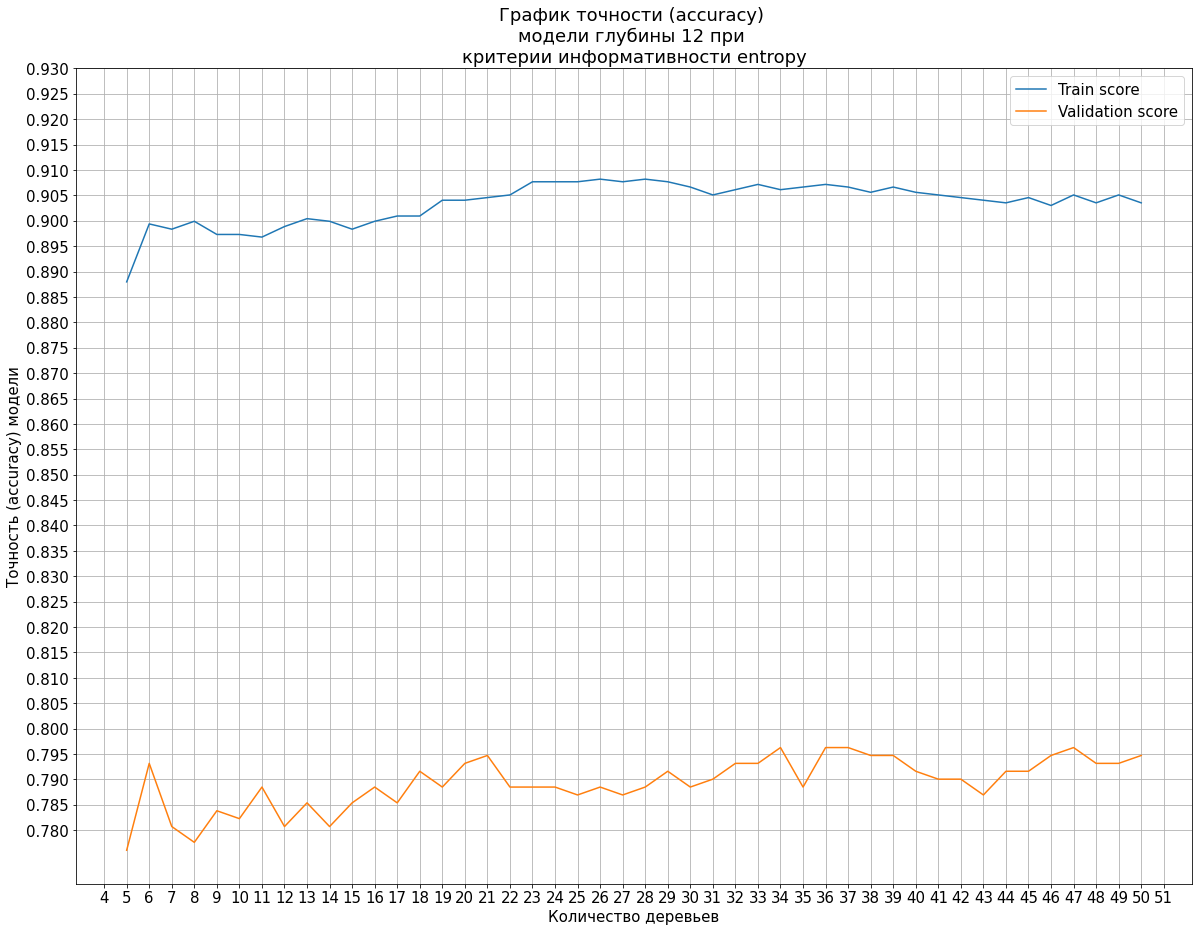

 80%|████████  | 8/10 [00:29<00:07,  3.98s/it]

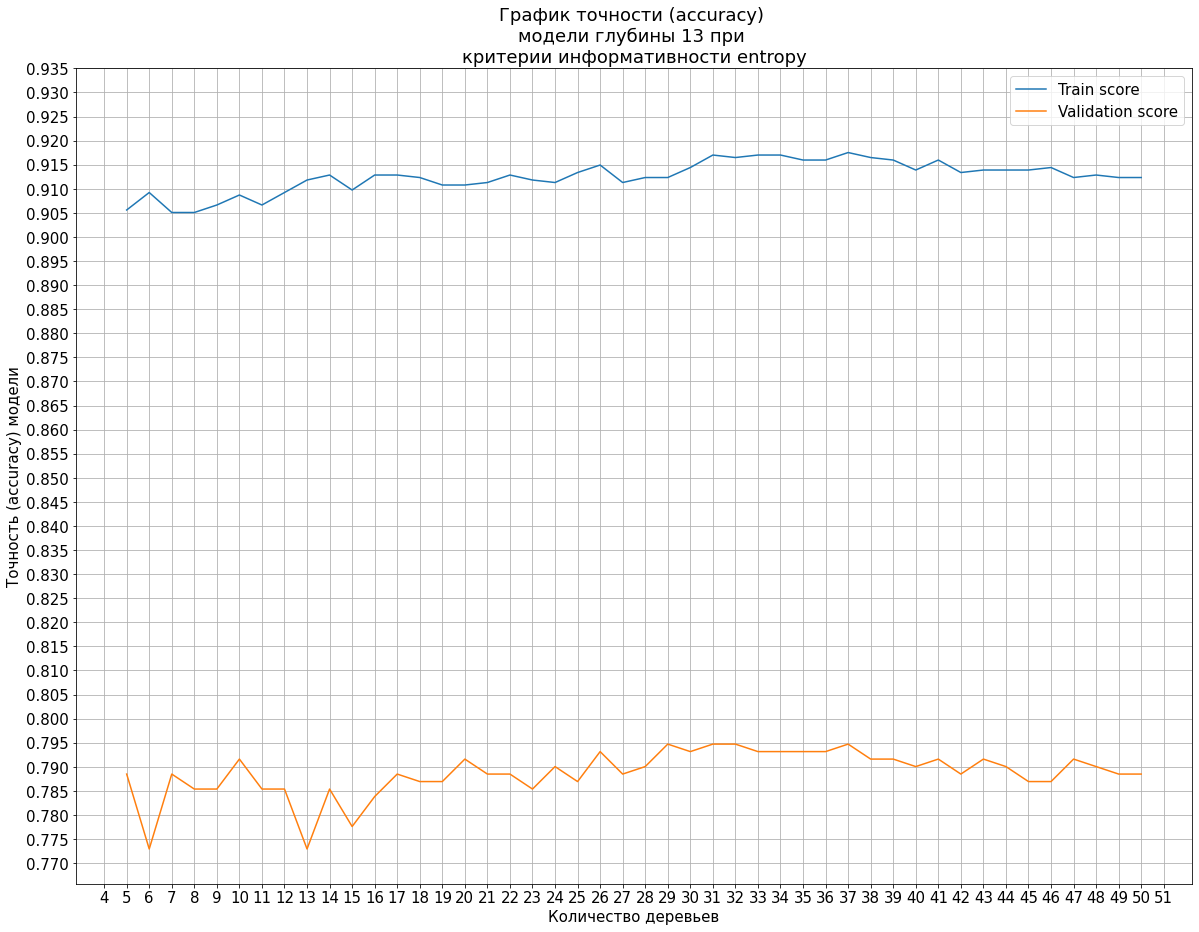

 90%|█████████ | 9/10 [00:33<00:04,  4.17s/it]

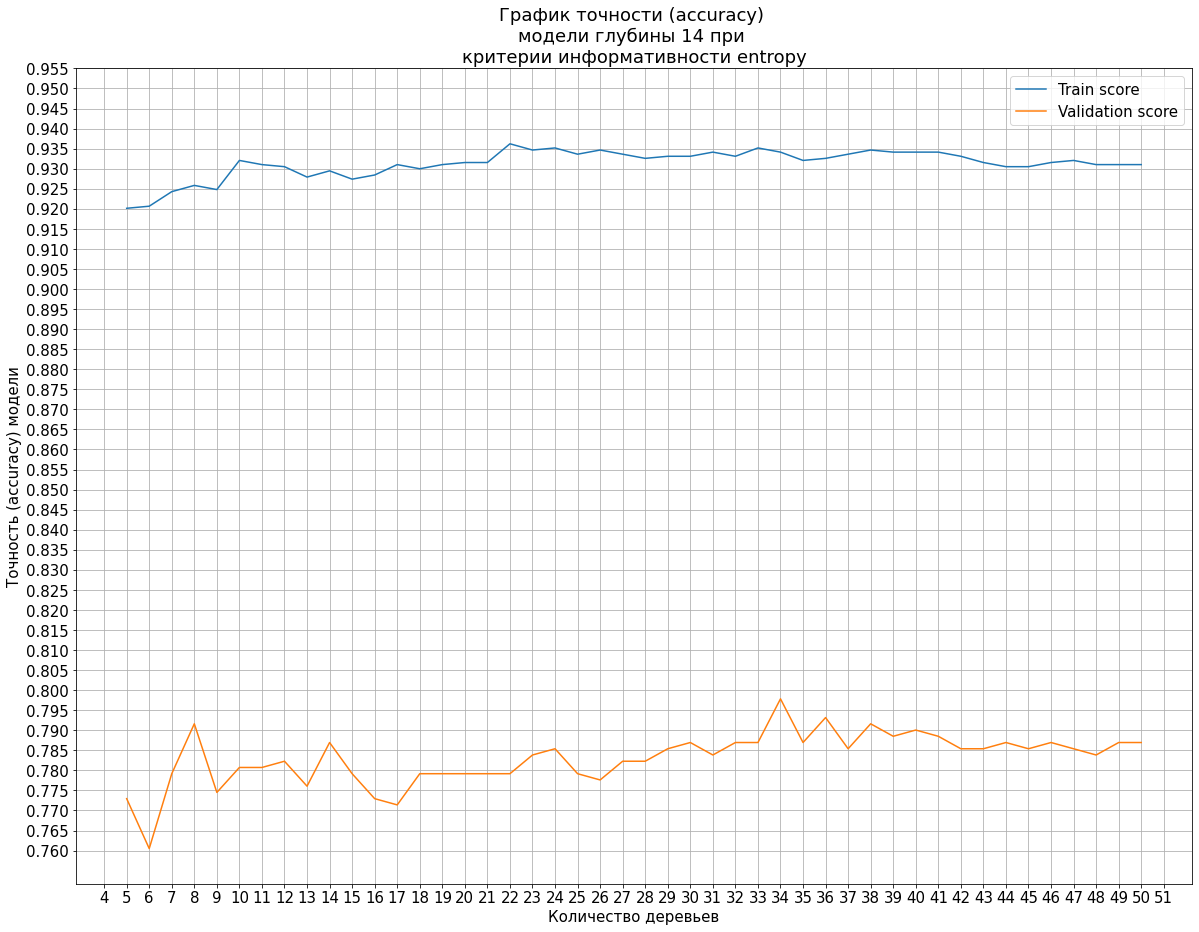

100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


In [22]:
best_rfc = None
best_depth = 0
best_est = 0
best_score = 0
best_criterion = None

for criterion in ['gini', 'entropy']:
    for depth in tqdm(range(5, 15)):
        train_score_plt = []
        val_score_plt = []
        est_plt = []
        for est in range(5,51):
            rfc = RandomForestClassifier(
                random_state=1337,
                max_depth=depth,
                criterion=criterion,
                n_estimators=est)
            rfc.fit(X_train, y_train)
            score = rfc.score(X_val, y_val)
            train_score_plt.append(rfc.score(X_train, y_train))
            val_score_plt.append(score)
            est_plt.append(est)
            if score > best_score:
                best_rfc = rfc
                best_score = score
                best_depth = depth
                best_est = est
                best_criterion = criterion
                
        plt.rcParams.update({'font.size': 15})
        plt.figure(figsize=(20,15))
        plt.plot(est_plt, train_score_plt, label='Train score')
        plt.plot(est_plt, val_score_plt, label='Validation score')
        plt.xticks(range(4,52))
        plt.yticks(np.arange(round(min(val_score_plt), 2), round(max(train_score_plt)+0.02, 2), 0.005))
        plt.xlabel('Количество деревьев')
        plt.ylabel('Точность (accuracy) модели')
        plt.title(f'График точности (accuracy) \nмодели глубины {depth} при \nкритерии информативности {criterion}')
        plt.grid(True)
        plt.legend()
        plt.show()

In [23]:
print(f'Лучшая модель случайного леса показала долю правильных ответов {best_score}.')
print(f'Глубина дерева: {best_depth}, число деревьев: {best_est}, критерий: {best_criterion}.')

Лучшая модель случайного леса показала долю правильных ответов 0.8180404354587869.
Глубина дерева: 10, число деревьев: 35, критерий: entropy.


Мы получили хорошую долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

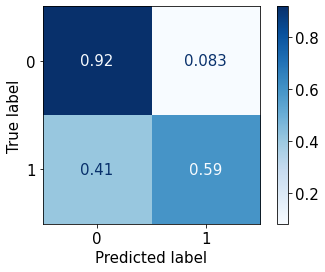

In [24]:
plot_confusion_matrix(estimator=best_rfc, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

Видно, что модель хорошо определяет истинно отрицательные значения (>90%), и определяет истинно положительные с точностью лучше случайной (~60%). 

### Логистическая регрессия

Логистическая регрессия. Мы будем исследовать следующие гиперпараметры:
- алгоритм оптимизации (lbfgs, liblinear, newton-cg, sag, saga);
- тип штрафа регуляризации (без штрафа, l1, l2, elasticnet);
- соотношение штрафа l1 к l2 (от 0.0 до 1.0 с шагом в 0.1 у типа регуляризации elasticnet).

Обучим модель и переберём разные значения гиперпараметров в цикле.
При исследовании модели в лог будет выводиться техническая информация.

In [25]:
best_lr = None
best_score = 0
best_solver = None
best_penalty = None

solver_penalties = {
    'lbfgs':['l2', 'none'],
    'liblinear': ['l1', 'l2'],
    'newton-cg': ['l2', 'none'],
    'sag': ['l2', 'none'],
    'saga': ['elasticnet', 'l1', 'l2', 'none']
}

for solver in solver_penalties:
    for penalty in solver_penalties[solver]:
        if penalty == 'elasticnet':
            for l1_ratio in np.linspace(0, 1, 11):
                lr = LogisticRegression(
                    random_state=1337, 
                    solver=solver, 
                    penalty=penalty, 
                    max_iter=100,
                    l1_ratio=l1_ratio)
                lr.fit(X_train, y_train)
                score = lr.score(X_val, y_val)
                print(f'Accuracy: {score}')
                print(f'Solver: {solver}, penalty: {penalty}, l1_ratio: {l1_ratio}')
                print('-' * 37)
                if score > best_score:
                    best_lr = lr
                    best_score = score
                    best_solver = solver
                    best_penalty = penalty
                    best_l1_ratio = l1_ratio
        else:
            lr = LogisticRegression(
                    random_state=1337, 
                    solver=solver, 
                    penalty=penalty, 
                    max_iter=100)
            lr.fit(X_train, y_train)
            score = lr.score(X_val, y_val)
            print(f'Accuracy: {score}')
            print(f'Solver: {solver}, penalty: {penalty}')
            print('-' * 37)
            if score > best_score:
                best_lr = lr
                best_score = score
                best_solver = solver
                best_penalty = penalty
        

Accuracy: 0.7293934681181959
Solver: lbfgs, penalty: l2
-------------------------------------
Accuracy: 0.7293934681181959
Solver: lbfgs, penalty: none
-------------------------------------
Accuracy: 0.7293934681181959
Solver: liblinear, penalty: l1
-------------------------------------
Accuracy: 0.7293934681181959
Solver: liblinear, penalty: l2
-------------------------------------
Accuracy: 0.7293934681181959
Solver: newton-cg, penalty: l2
-------------------------------------
Accuracy: 0.7293934681181959
Solver: newton-cg, penalty: none
-------------------------------------
Accuracy: 0.7293934681181959
Solver: sag, penalty: l2
-------------------------------------
Accuracy: 0.7293934681181959
Solver: sag, penalty: none
-------------------------------------
Accuracy: 0.7293934681181959
Solver: saga, penalty: elasticnet, l1_ratio: 0.0
-------------------------------------
Accuracy: 0.7293934681181959
Solver: saga, penalty: elasticnet, l1_ratio: 0.1
------------------------------------

In [26]:
print(f'Лучшая модель логистической регрессии показала долю правильных ответов {best_score}.')
print(f'Алгоритм оптимизации: {best_solver}, класс регуляризации: {best_penalty}.')

Лучшая модель логистической регрессии показала долю правильных ответов 0.7293934681181959.
Алгоритм оптимизации: lbfgs, класс регуляризации: l2.


Мы получили неудовлетворительную долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

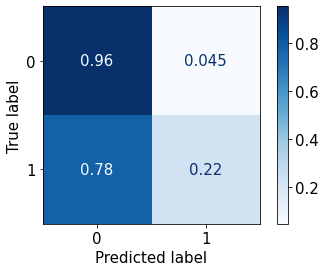

In [27]:
plot_confusion_matrix(estimator=best_lr, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

Видно, что модель очень хорошо определяет истинно отрицательные значения (>95%), и ужасно справляется с определением истинно положительных (~22%). 

### Градиентный бустинг CatBoost

Градиентный бустинг CatBoost. Мы будем исследовать следующие гиперпараметры:
- глубина дерева (от 5 до 10);
- количество деревьев (100, 500, 1000 или 2000);
- значение штрафа l2 регуляризации (3, 6, 20, 50 или 100).

Обучим модель и переберём разные значения гиперпараметров в цикле.
При исследовании модели в лог будeт выводиться графики.

  0%|          | 0/4 [00:00<?, ?it/s]

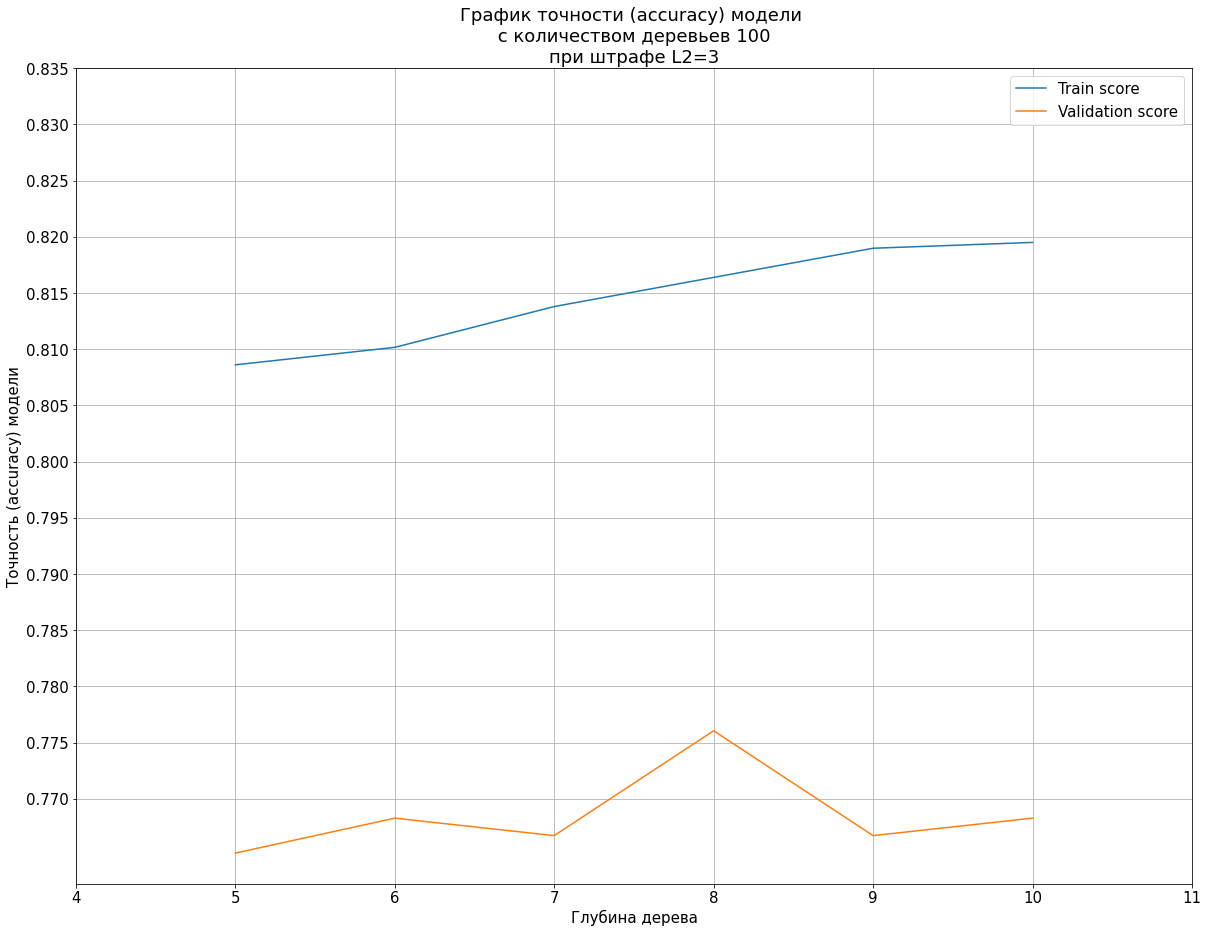

 25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

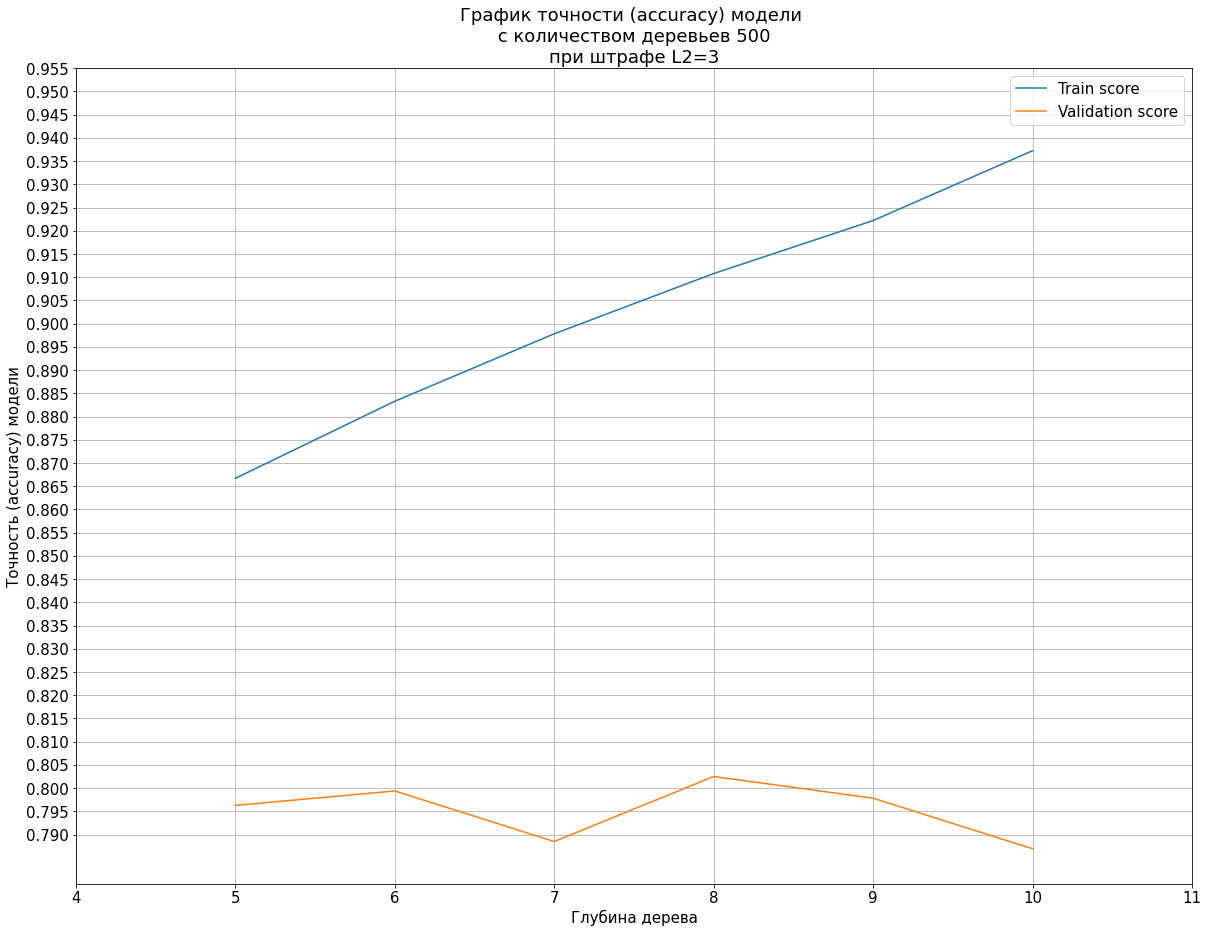

 50%|█████     | 2/4 [00:14<00:15,  7.92s/it]

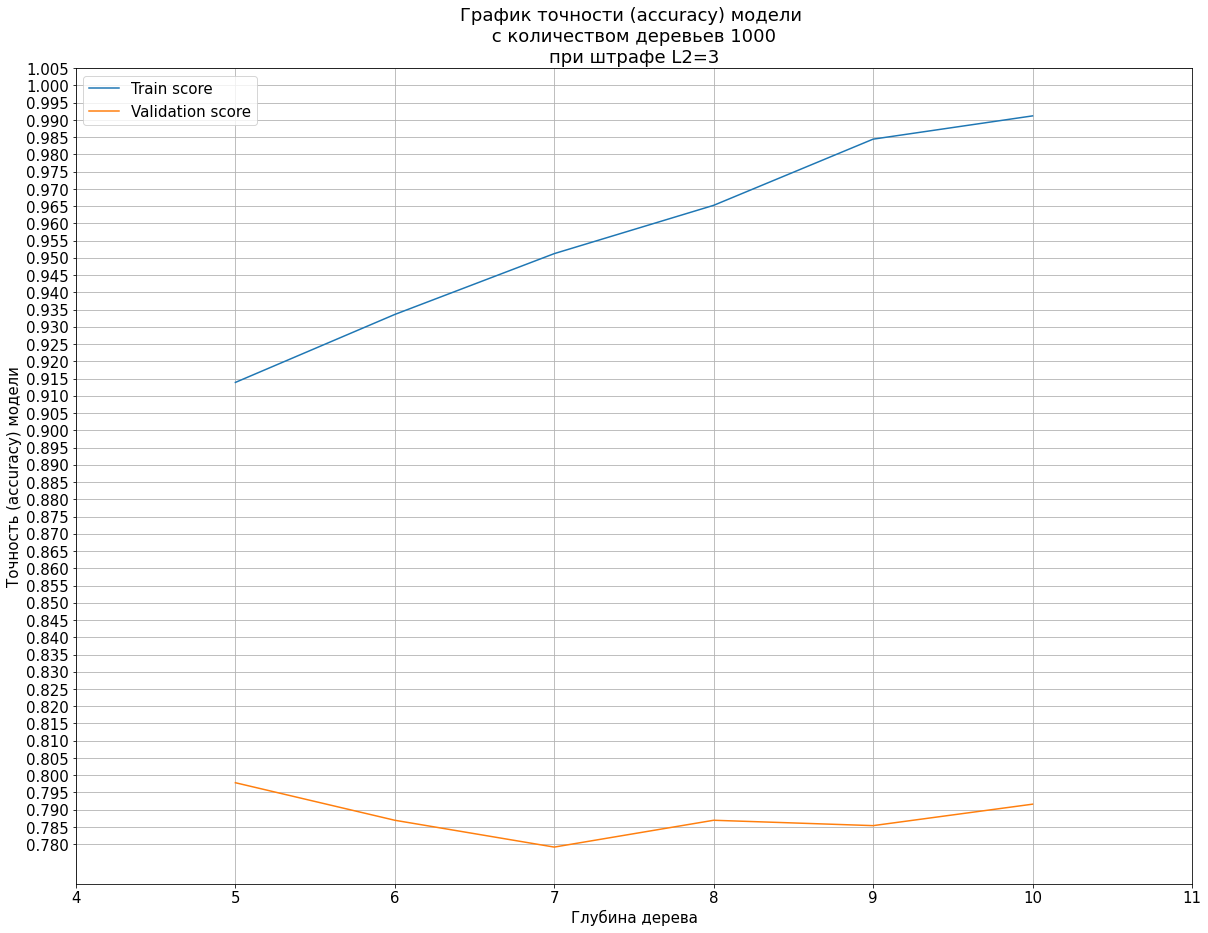

 75%|███████▌  | 3/4 [00:38<00:15, 15.62s/it]

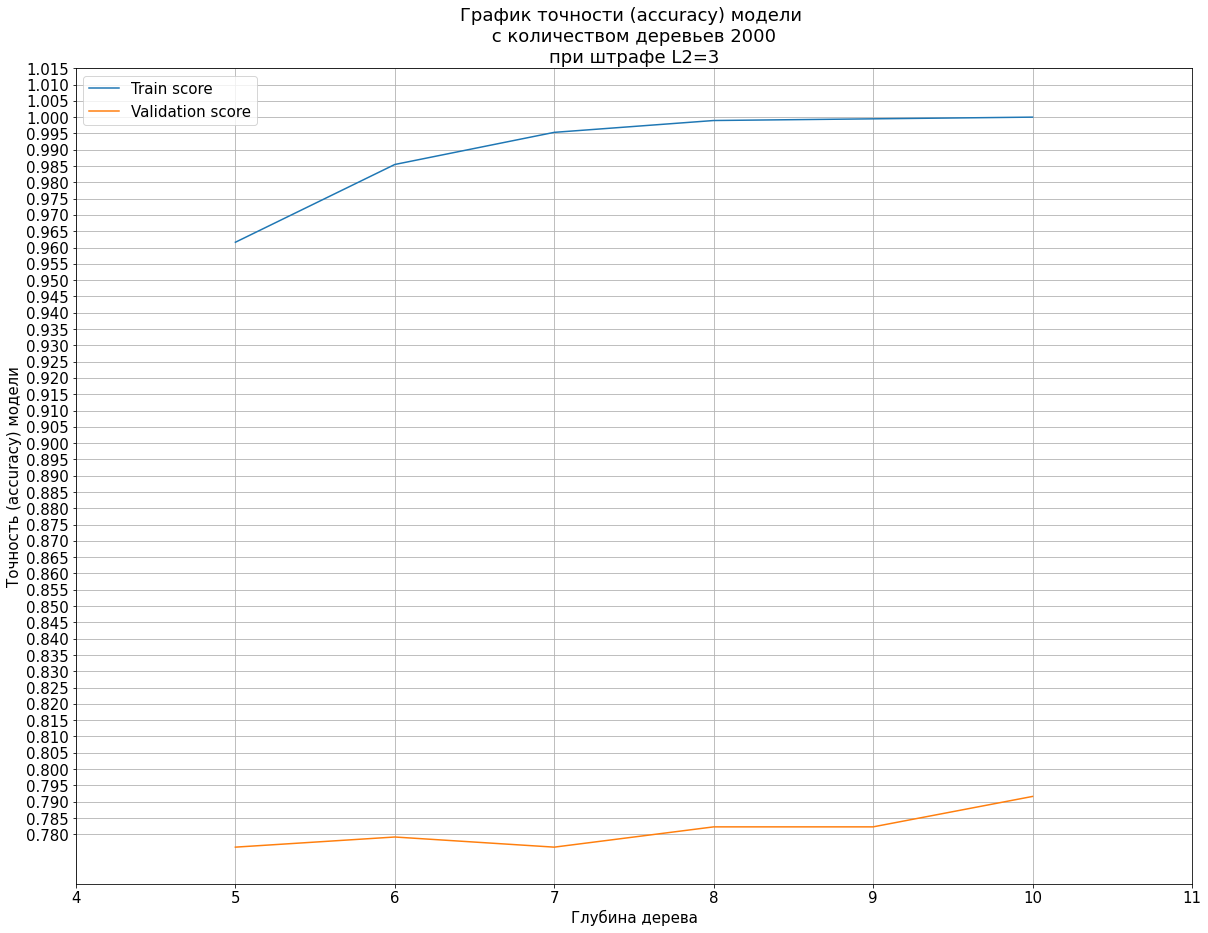

  0%|          | 0/4 [00:00<?, ?it/s]

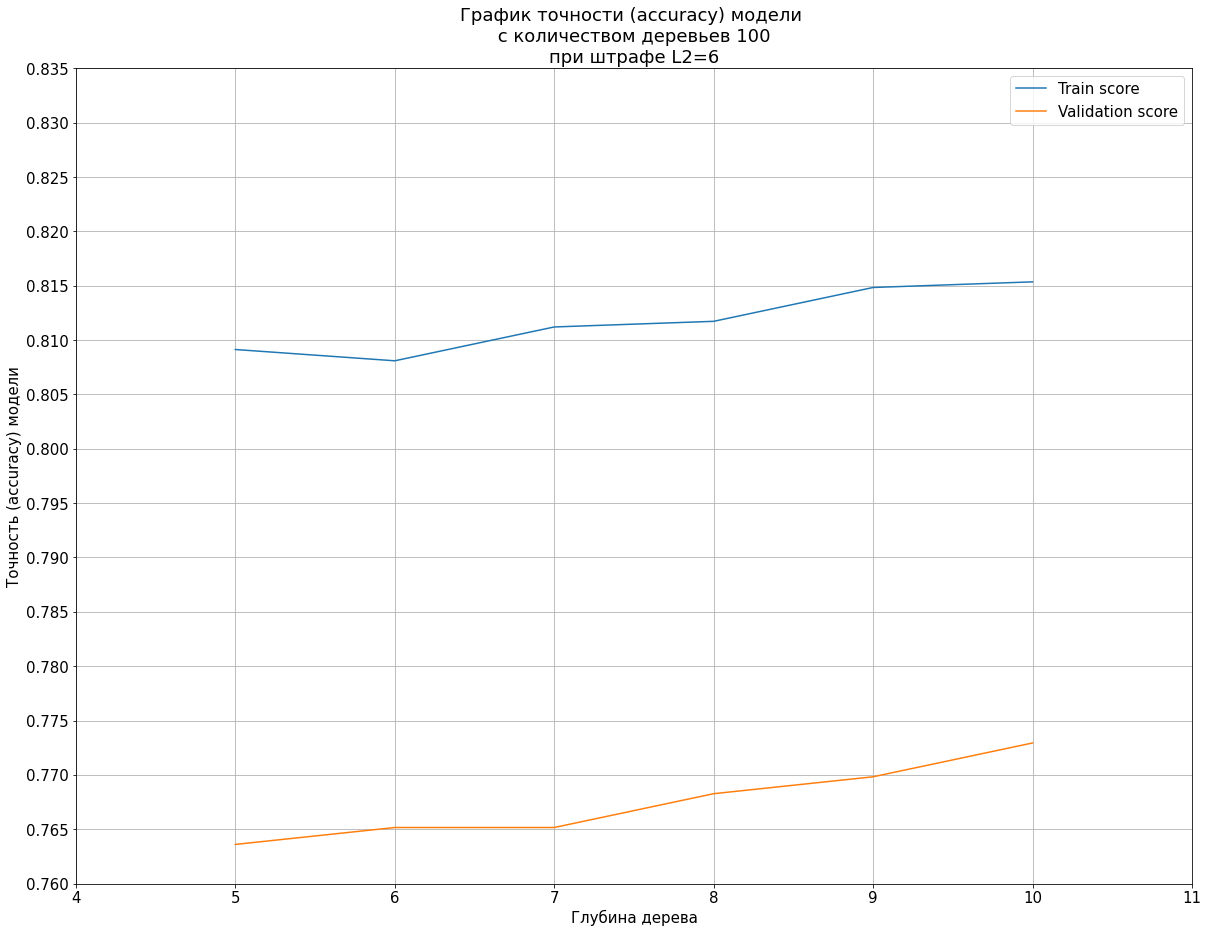

 25%|██▌       | 1/4 [00:02<00:07,  2.48s/it]

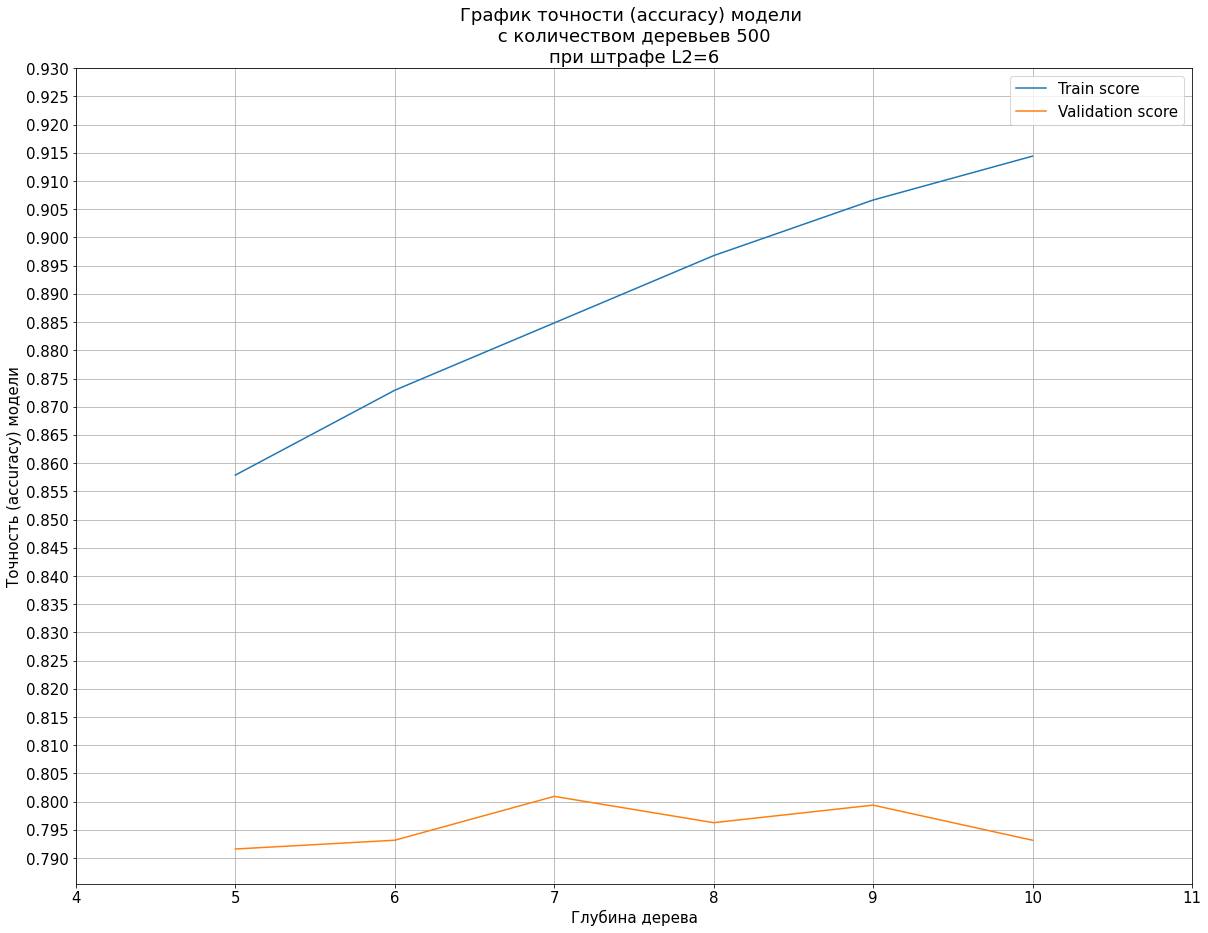

 50%|█████     | 2/4 [00:15<00:17,  8.93s/it]

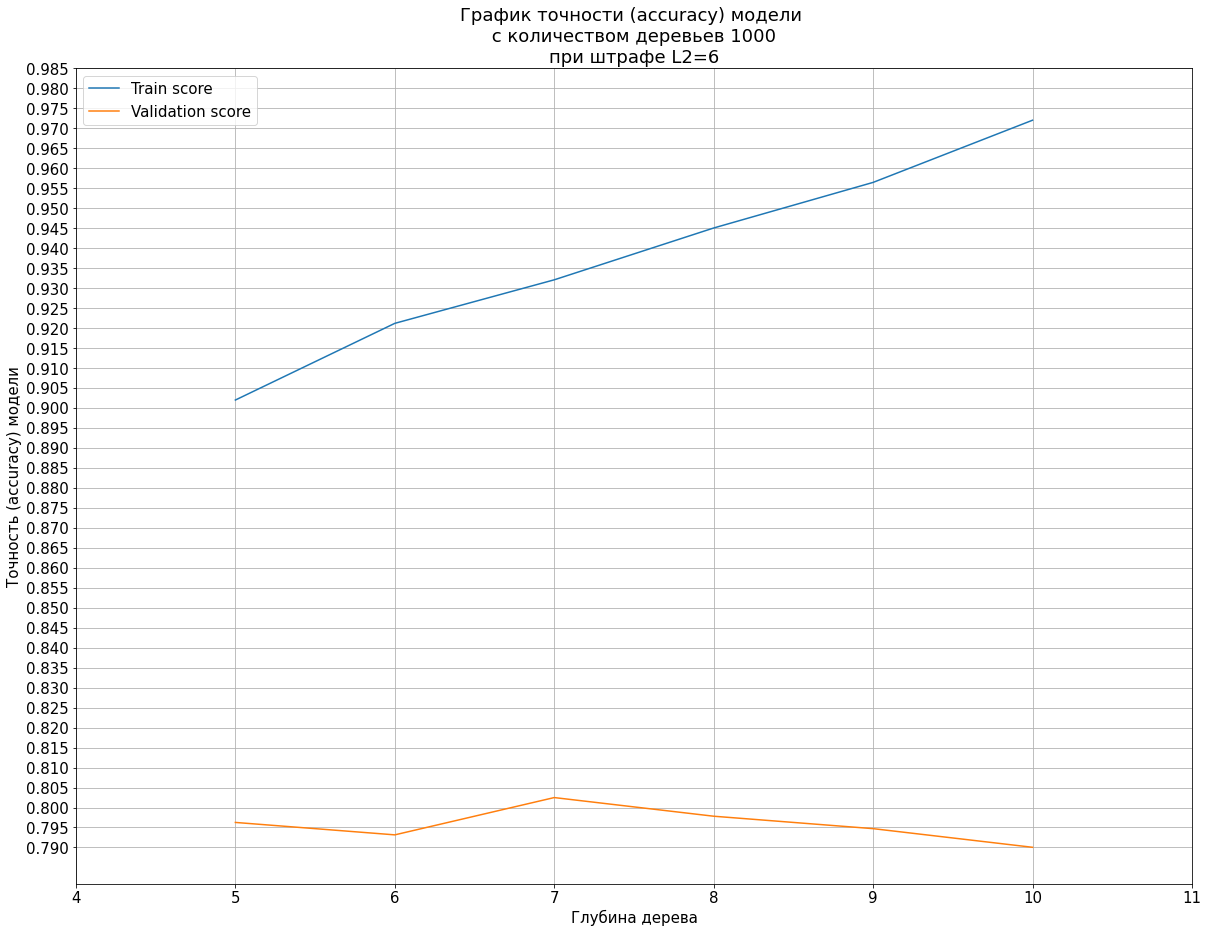

 75%|███████▌  | 3/4 [00:42<00:17, 17.04s/it]

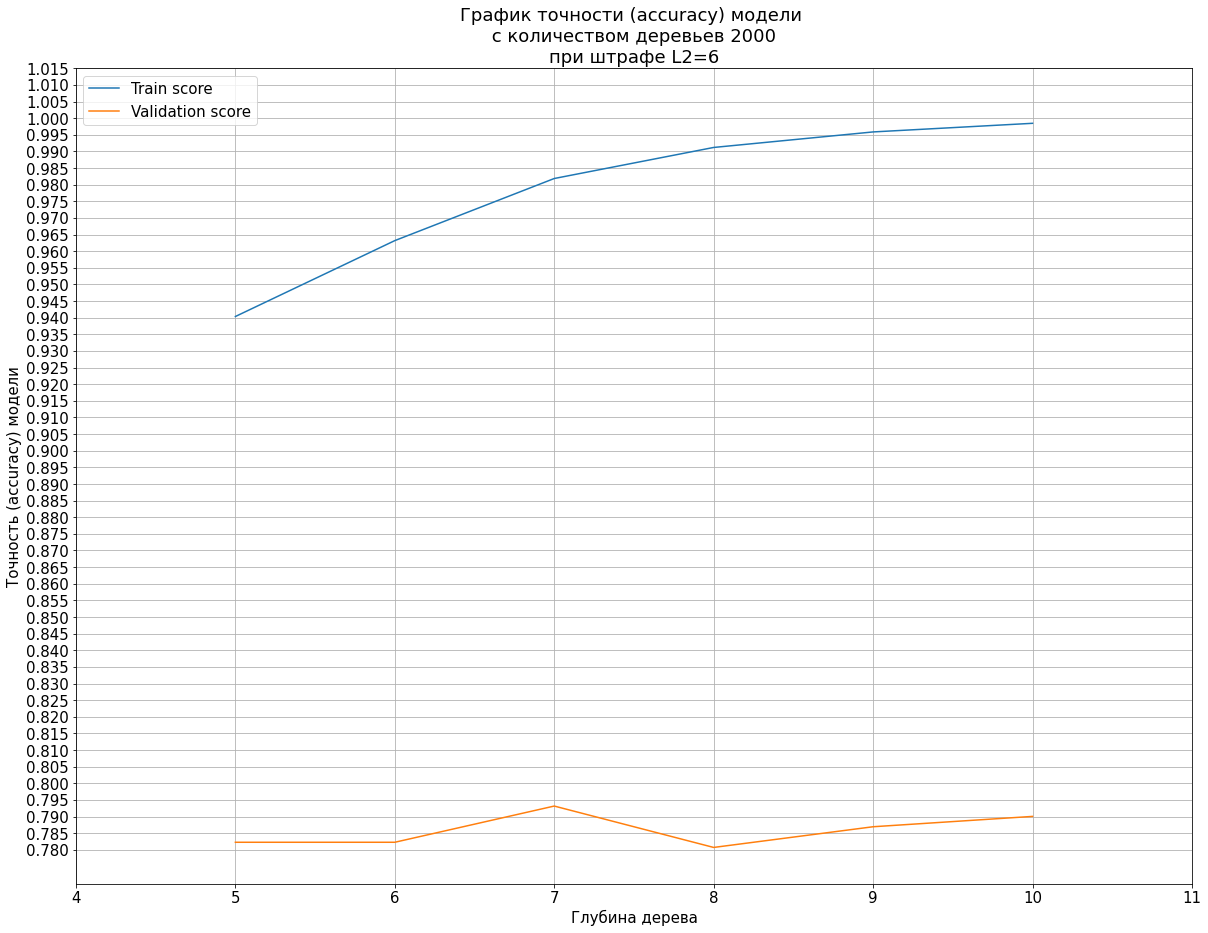

  0%|          | 0/4 [00:00<?, ?it/s]

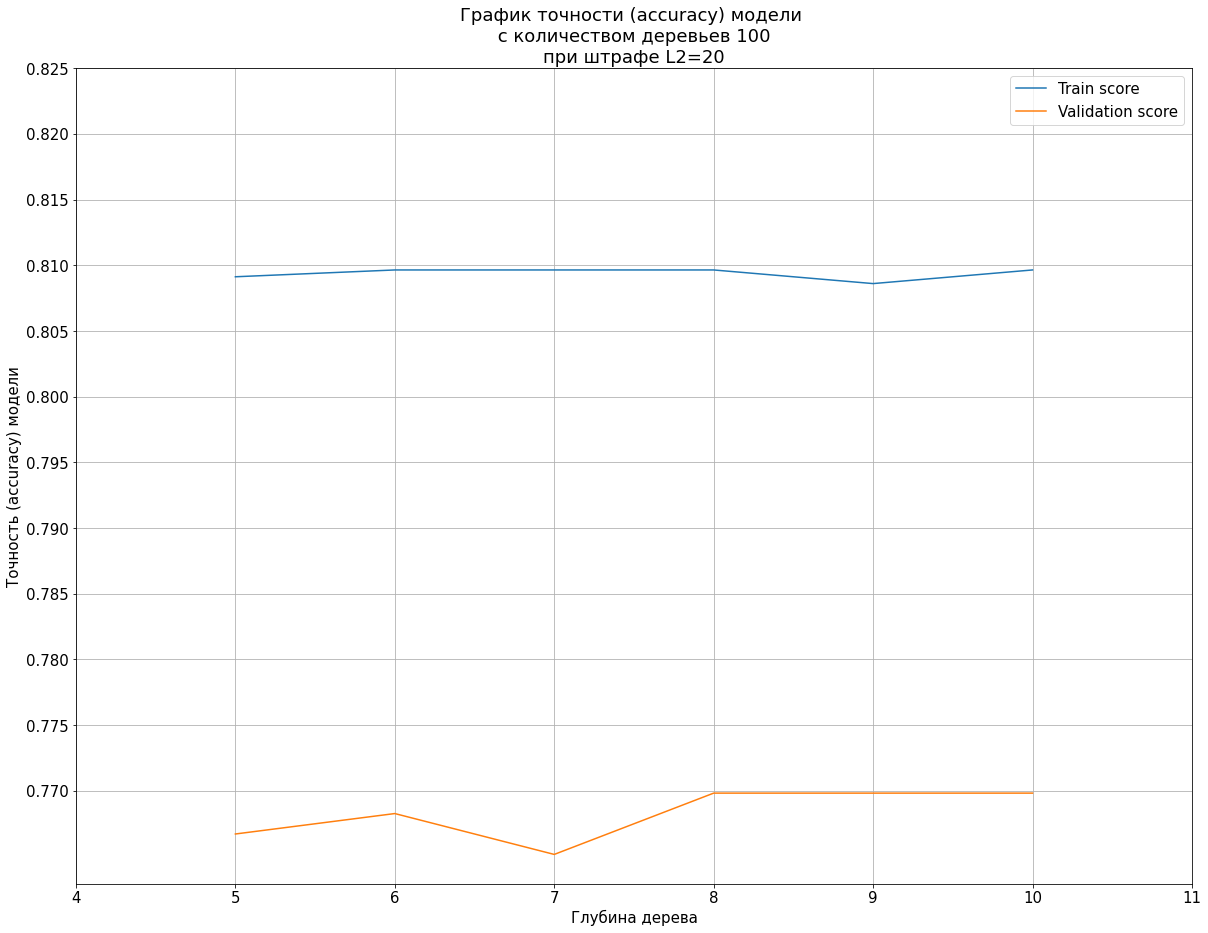

 25%|██▌       | 1/4 [00:02<00:07,  2.40s/it]

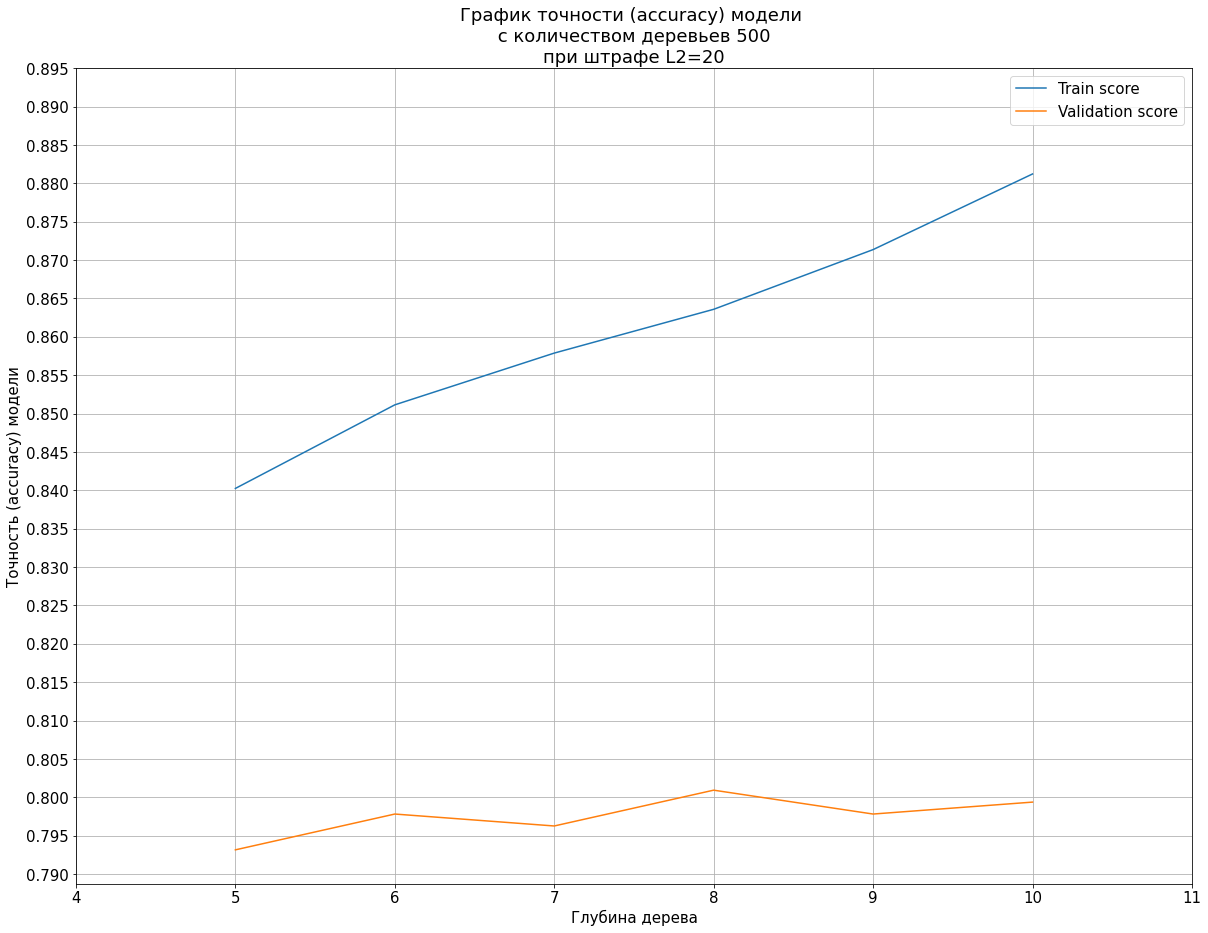

 50%|█████     | 2/4 [00:16<00:18,  9.02s/it]

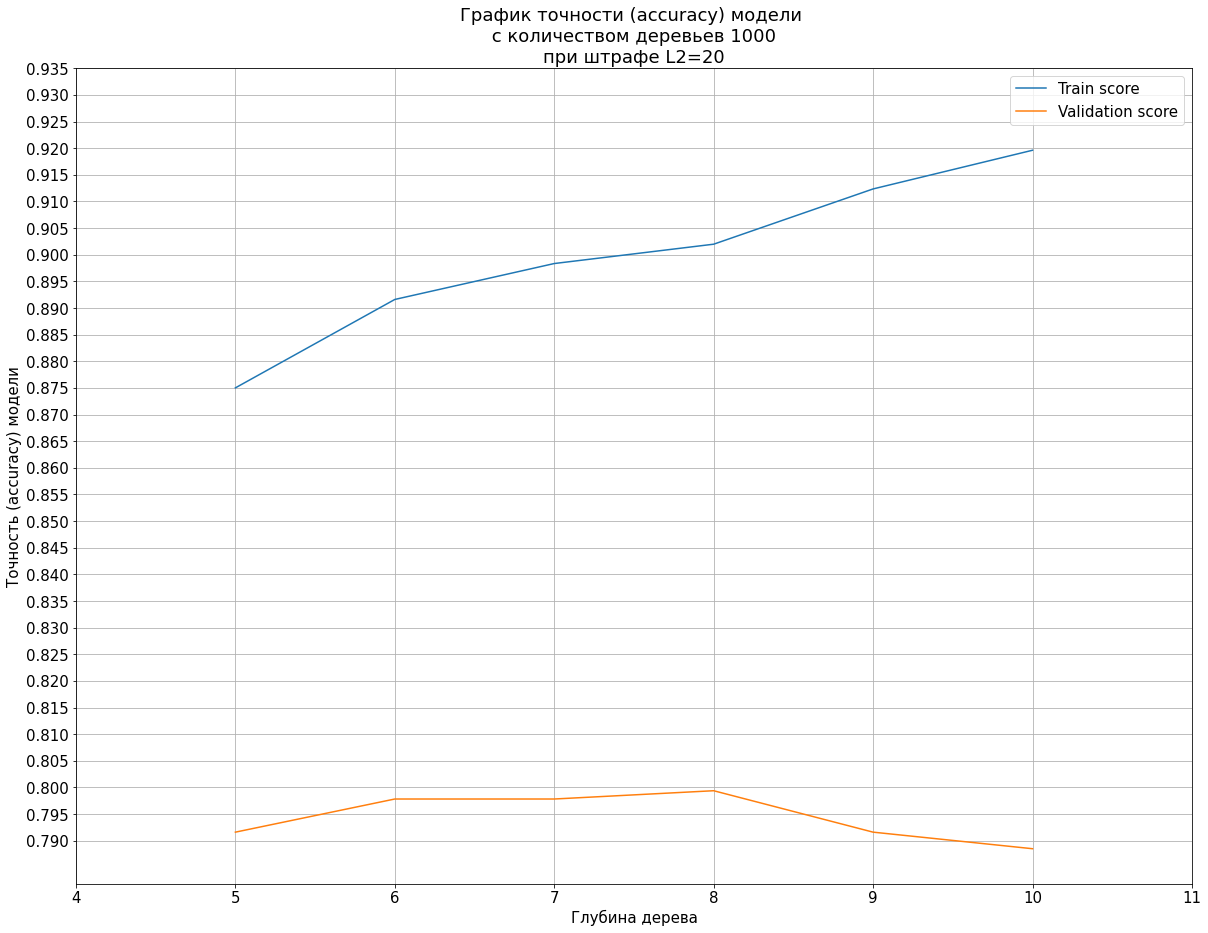

 75%|███████▌  | 3/4 [00:42<00:16, 16.94s/it]

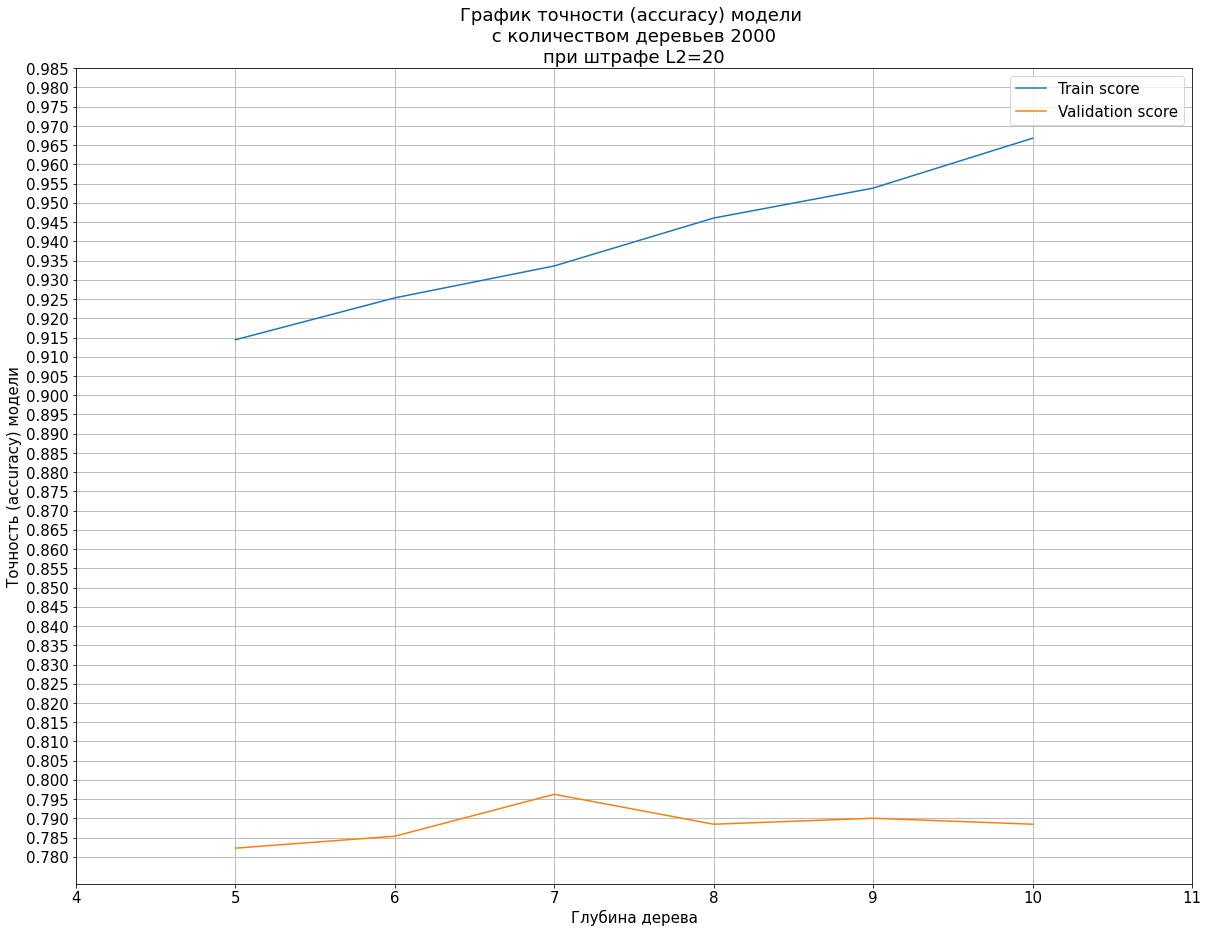

  0%|          | 0/4 [00:00<?, ?it/s]

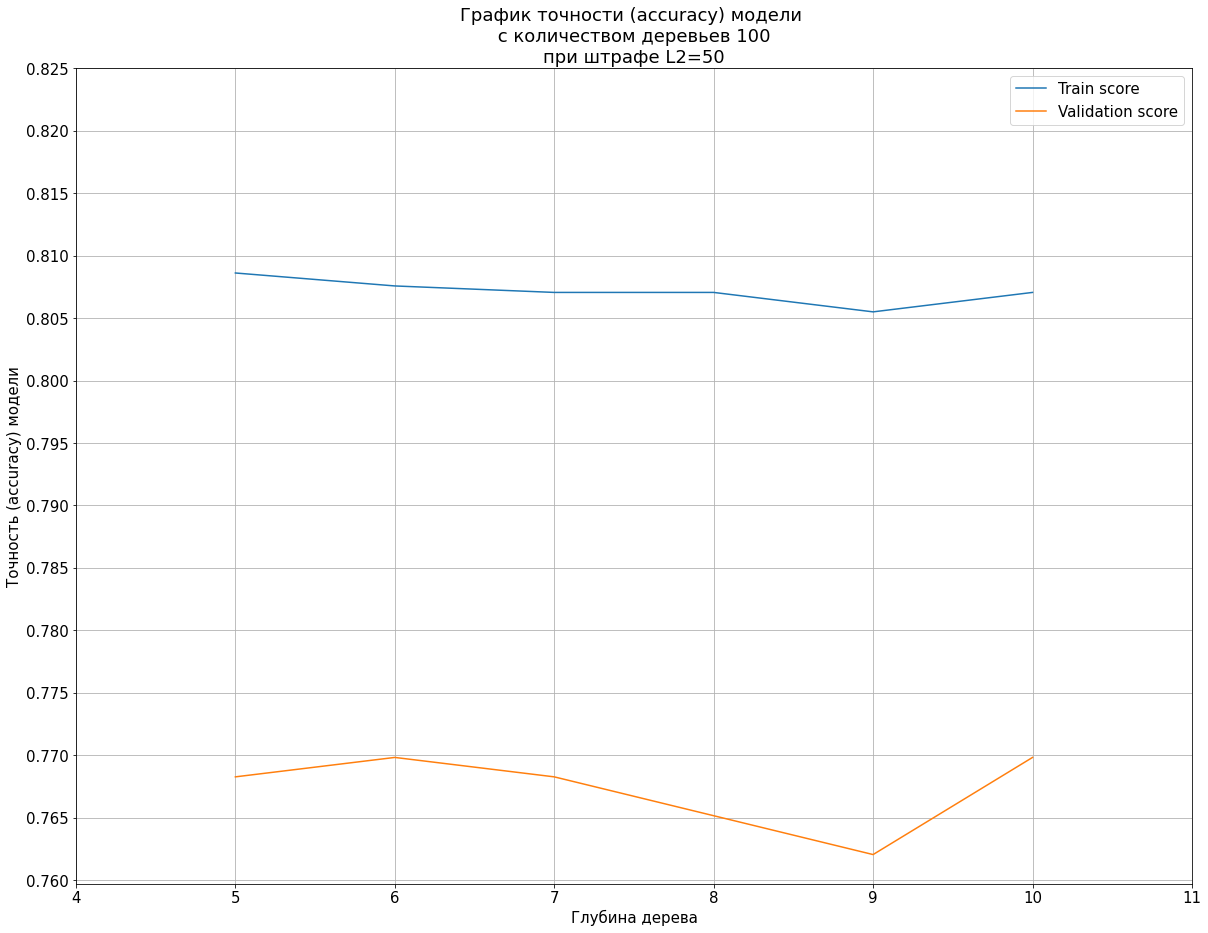

 25%|██▌       | 1/4 [00:02<00:07,  2.43s/it]

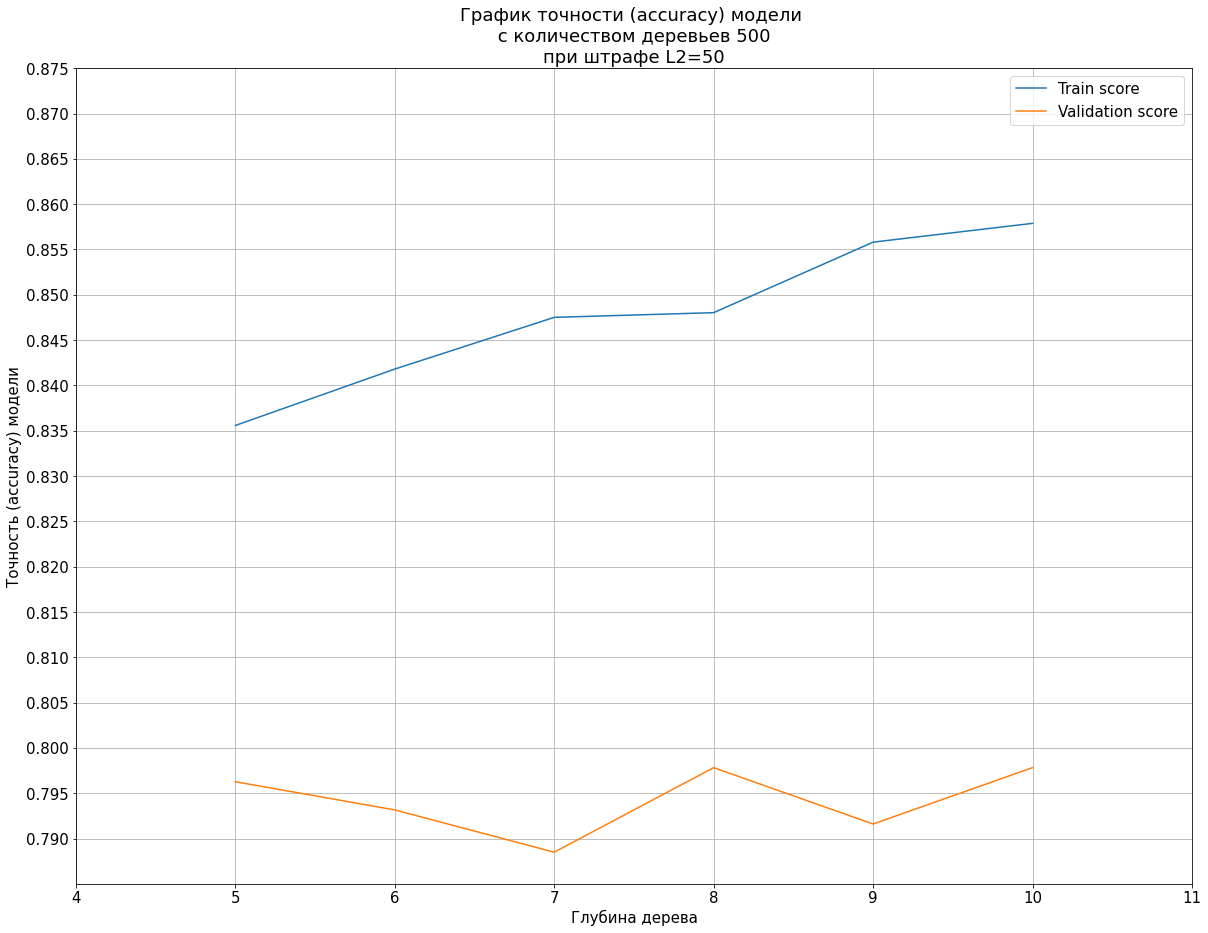

 50%|█████     | 2/4 [00:15<00:17,  8.92s/it]

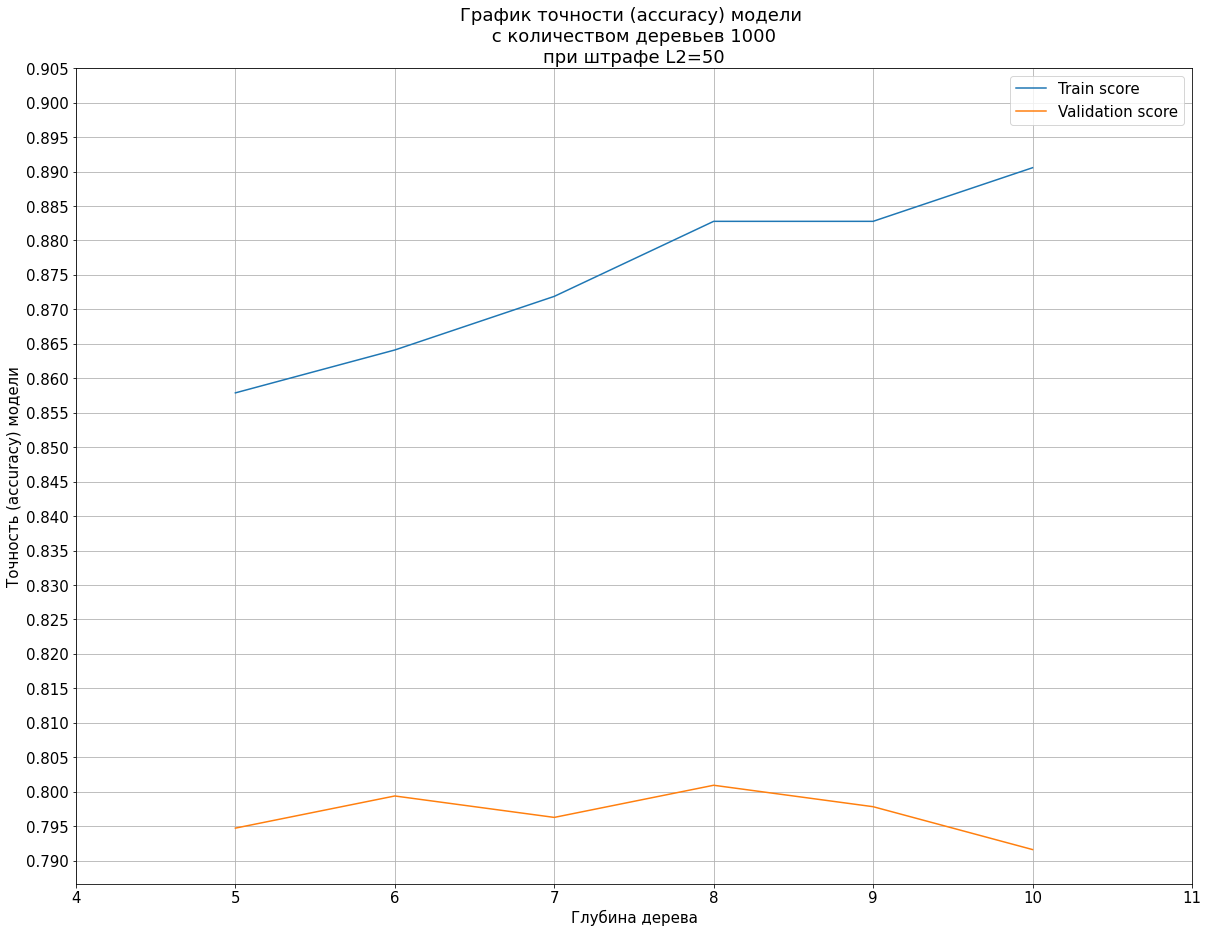

 75%|███████▌  | 3/4 [00:41<00:16, 16.75s/it]

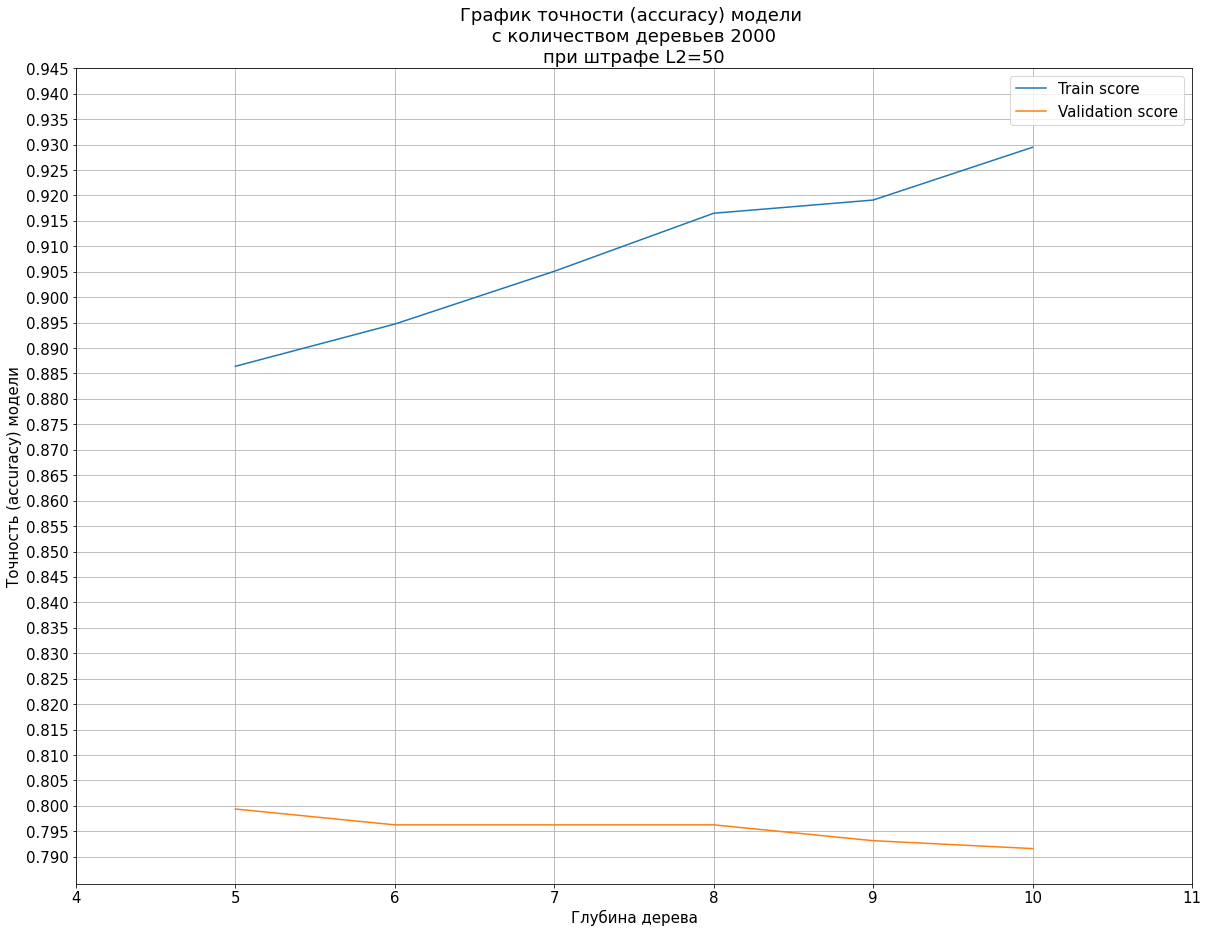

  0%|          | 0/4 [00:00<?, ?it/s]

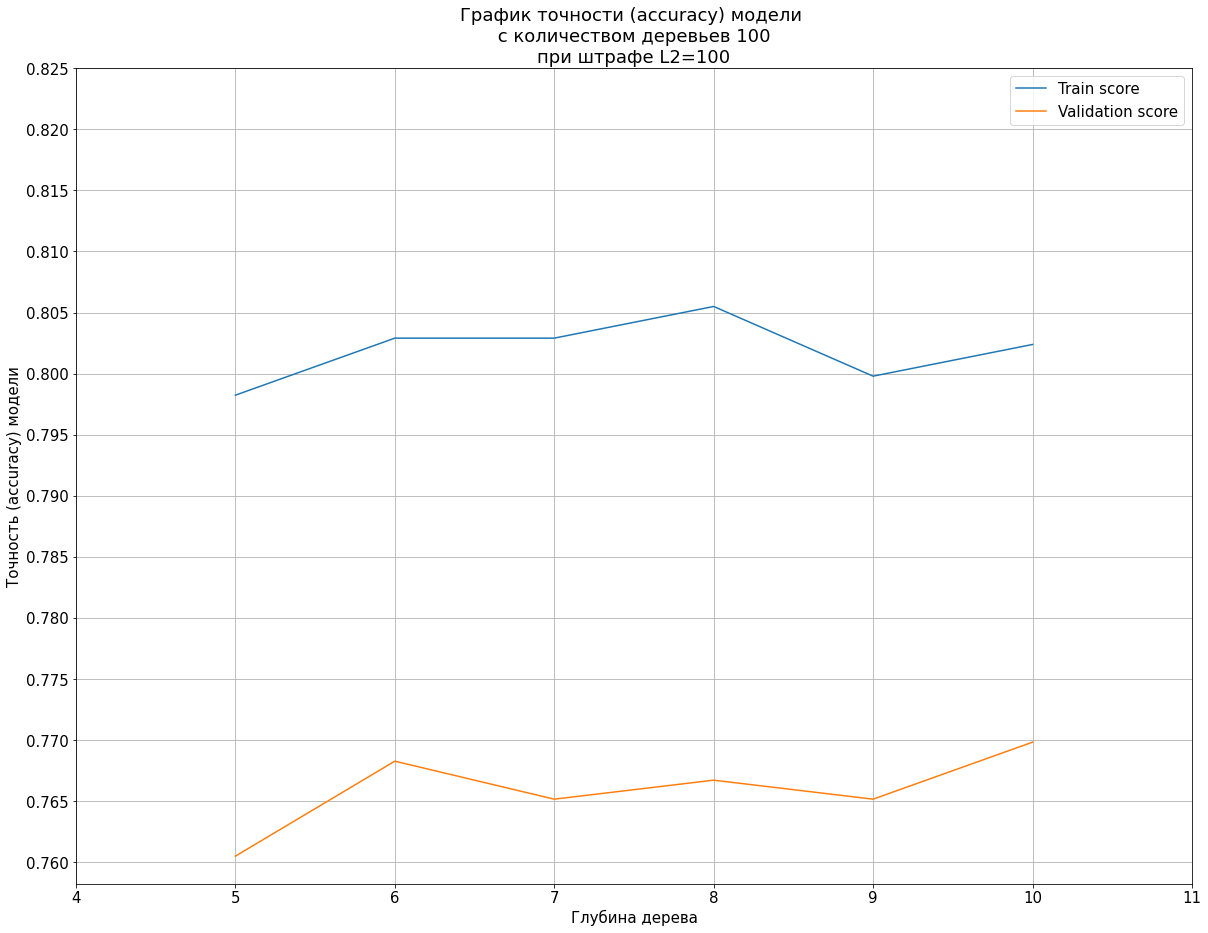

 25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

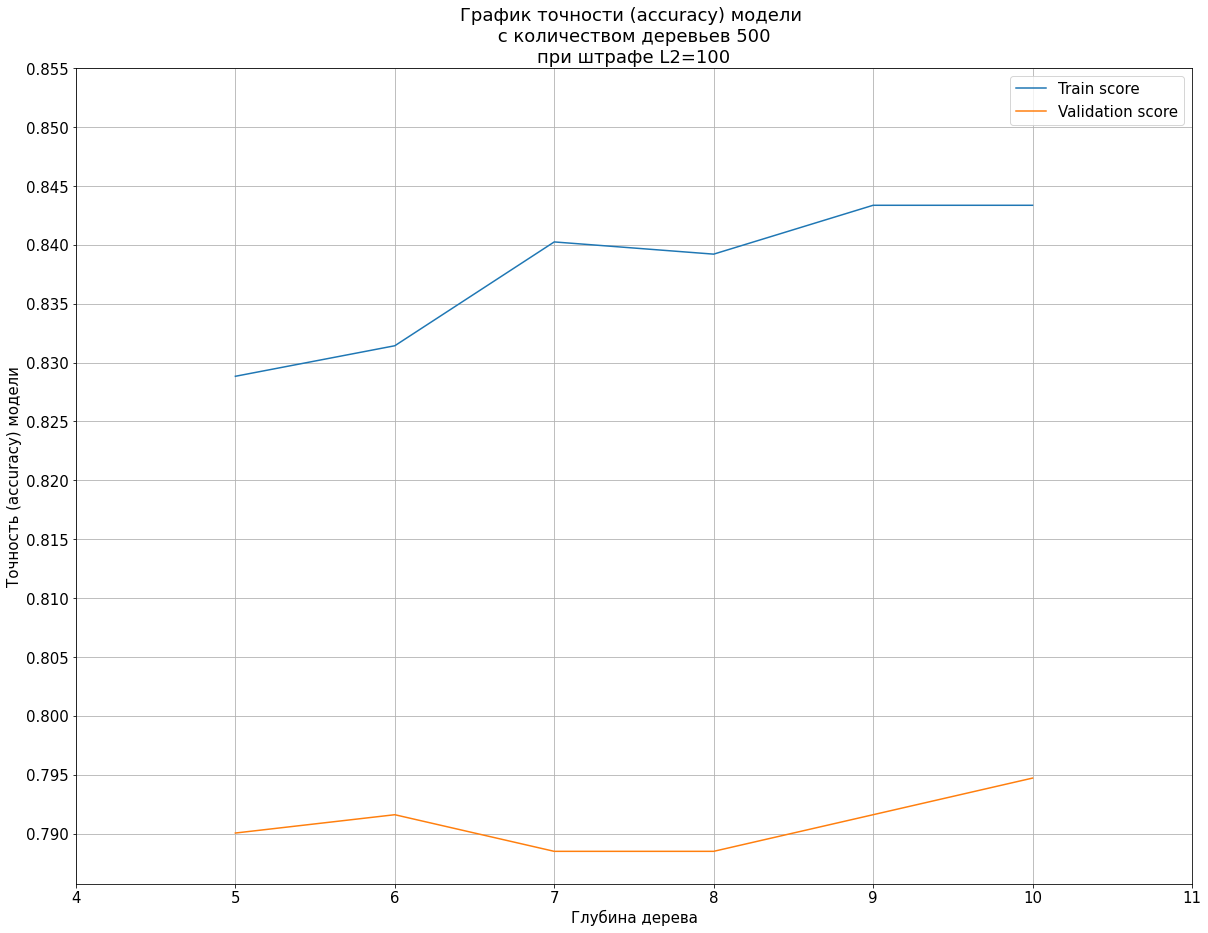

 50%|█████     | 2/4 [00:14<00:16,  8.14s/it]

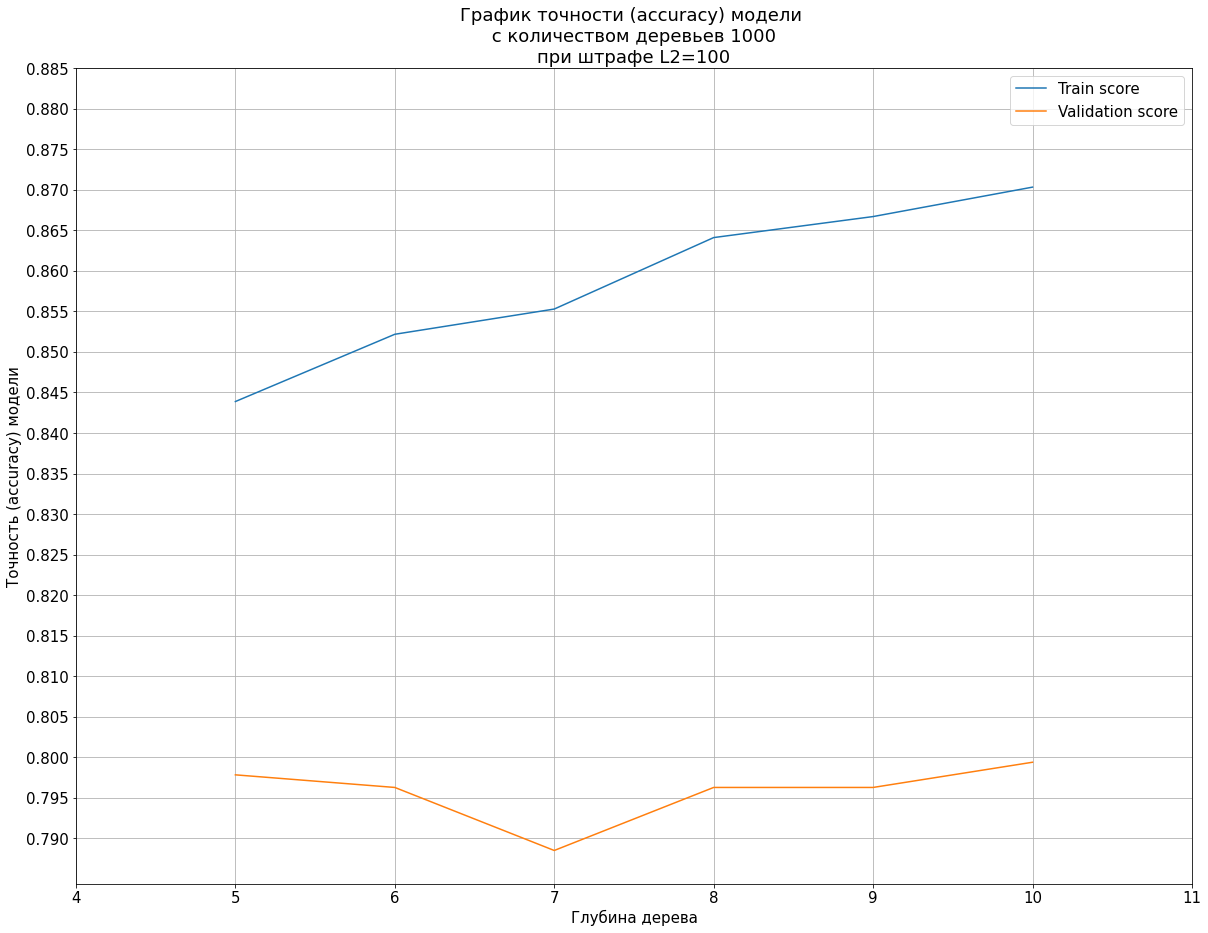

 75%|███████▌  | 3/4 [00:40<00:16, 16.37s/it]

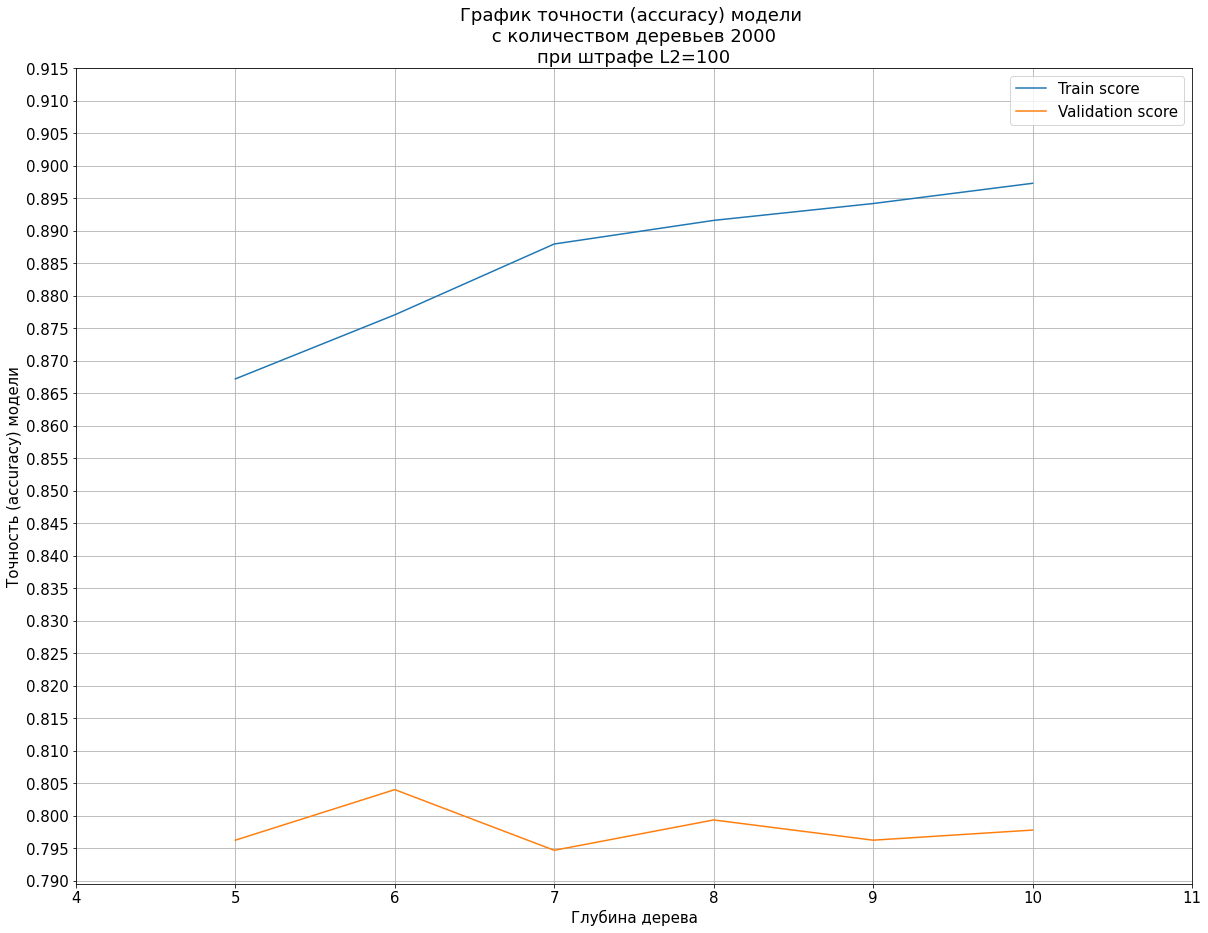

100%|██████████| 4/4 [01:33<00:00, 23.31s/it]


In [28]:
best_cbc = None
best_score = 0
best_n_tree = 0
best_depth = 0
best_l2 = 0

for l2 in [3, 6, 20, 50, 100]:
    for n_tree in tqdm([100, 500, 1000, 2000]):
        train_score_plt = []
        val_score_plt = []
        depth_plt = []
        for depth in range(5,11):
            cbc = CatBoostClassifier(
                iterations=n_tree,
                l2_leaf_reg=l2,
                depth=depth,
                logging_level='Silent',
                random_state=1337)
            cbc.fit(X_train, y_train)
            score = cbc.score(X_val, y_val)
            train_score_plt.append(cbc.score(X_train, y_train))
            val_score_plt.append(score)
            depth_plt.append(depth)
            if score > best_score:
                best_cbc = cbc
                best_score = score
                best_n_tree = n_tree
                best_depth = depth
                best_l2 = l2            
        
        plt.rcParams.update({'font.size': 15})
        plt.figure(figsize=(20,15))
        plt.plot(depth_plt, train_score_plt, label='Train score')
        plt.plot(depth_plt, val_score_plt, label='Validation score')
        plt.xticks(range(4,12))
        plt.yticks(np.arange(round(min(val_score_plt), 2), round(max(train_score_plt)+0.02, 2), 0.005))
        plt.xlabel('Глубина дерева')
        plt.ylabel('Точность (accuracy) модели')
        plt.title(f'График точности (accuracy) модели \n с количеством деревьев {n_tree} \nпри штрафе L2={l2}')
        plt.grid(True)
        plt.legend()
        plt.show()

In [29]:
print(f'Лучшая модель градиентного бустинга CatBoost показала долю правильных ответов {best_score}.')
print(f'Количество деревьев: {best_n_tree}, глубина: {best_depth}, параметр регуляризации L2: {best_l2}.')

Лучшая модель градиентного бустинга CatBoost показала долю правильных ответов 0.8040435458786936.
Количество деревьев: 2000, глубина: 6, параметр регуляризации L2: 100.


Мы получили хорошую долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

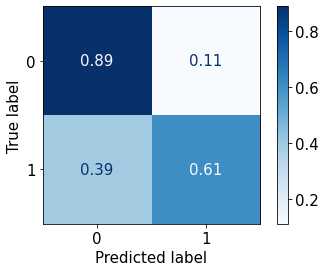

In [30]:
plot_confusion_matrix(estimator=best_cbc, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

Видно, что модель хорошо определяет истинно отрицательные значения (89%), и определяет истинно положительные с точностью лучше случайной (~60%). 

### Метод опорных векторов

Метод опорных векторов. Мы будем исследовать следующие гиперпараметры:
- ядерная функция (полиномиальное ядро, гауссово ядро с радиальной базовой функцией (RBF), сигмоидное ядро);
- квадратичный штраф регуляризации l2 (0.5, 2, 5, 10, 20, 100, 200, 500, 1000 или 2000);

Обучим модель и переберём разные значения гиперпараметров в цикле.
При исследовании модели в лог будет выводиться техническая информация.

In [31]:
best_svc = None
best_score = 0
best_kernel = None
best_c = 0

for kernel in tqdm([ 'poly', 'rbf', 'sigmoid']):
    for c in [0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000, 2000]:
        svc = SVC(
            random_state=1337,
            kernel=kernel,
            C=c
            )
        svc.fit(X_train, y_train)
        score = svc.score(X_val, y_val)
        print(f'Accuracy: {score}')
        print(f'Kernel: {kernel}, squared l2 penalty: {c}')
        print('-' * 37)
        if score > best_score:
                best_svc = svc
                best_score = score
                best_kernel = kernel
                best_c = c        

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 0.749611197511664
Kernel: poly, squared l2 penalty: 0.5
-------------------------------------
Accuracy: 0.7511664074650077
Kernel: poly, squared l2 penalty: 1
-------------------------------------
Accuracy: 0.7511664074650077
Kernel: poly, squared l2 penalty: 2
-------------------------------------
Accuracy: 0.7480559875583204
Kernel: poly, squared l2 penalty: 5
-------------------------------------
Accuracy: 0.749611197511664
Kernel: poly, squared l2 penalty: 10
-------------------------------------
Accuracy: 0.7511664074650077
Kernel: poly, squared l2 penalty: 20
-------------------------------------
Accuracy: 0.7511664074650077
Kernel: poly, squared l2 penalty: 100
-------------------------------------
Accuracy: 0.7527216174183515
Kernel: poly, squared l2 penalty: 200
-------------------------------------
Accuracy: 0.7527216174183515
Kernel: poly, squared l2 penalty: 500
-------------------------------------
Accuracy: 0.7527216174183515
Kernel: poly, squared l2 penalty: 10

 33%|███▎      | 1/3 [01:48<03:37, 108.73s/it]

Accuracy: 0.7527216174183515
Kernel: poly, squared l2 penalty: 2000
-------------------------------------
Accuracy: 0.7682737169517885
Kernel: rbf, squared l2 penalty: 0.5
-------------------------------------
Accuracy: 0.7729393468118196
Kernel: rbf, squared l2 penalty: 1
-------------------------------------
Accuracy: 0.7729393468118196
Kernel: rbf, squared l2 penalty: 2
-------------------------------------
Accuracy: 0.7729393468118196
Kernel: rbf, squared l2 penalty: 5
-------------------------------------
Accuracy: 0.7807153965785381
Kernel: rbf, squared l2 penalty: 10
-------------------------------------
Accuracy: 0.7838258164852255
Kernel: rbf, squared l2 penalty: 20
-------------------------------------
Accuracy: 0.7900466562986003
Kernel: rbf, squared l2 penalty: 100
-------------------------------------
Accuracy: 0.7962674961119751
Kernel: rbf, squared l2 penalty: 200
-------------------------------------
Accuracy: 0.7962674961119751
Kernel: rbf, squared l2 penalty: 500
----

 67%|██████▋   | 2/3 [01:54<00:48, 48.32s/it] 

Accuracy: 0.7853810264385692
Kernel: rbf, squared l2 penalty: 2000
-------------------------------------
Accuracy: 0.5878693623639192
Kernel: sigmoid, squared l2 penalty: 0.5
-------------------------------------
Accuracy: 0.5878693623639192
Kernel: sigmoid, squared l2 penalty: 1
-------------------------------------
Accuracy: 0.5878693623639192
Kernel: sigmoid, squared l2 penalty: 2
-------------------------------------
Accuracy: 0.5894245723172629
Kernel: sigmoid, squared l2 penalty: 5
-------------------------------------
Accuracy: 0.5909797822706065
Kernel: sigmoid, squared l2 penalty: 10
-------------------------------------
Accuracy: 0.5894245723172629
Kernel: sigmoid, squared l2 penalty: 20
-------------------------------------
Accuracy: 0.5909797822706065
Kernel: sigmoid, squared l2 penalty: 100
-------------------------------------
Accuracy: 0.5909797822706065
Kernel: sigmoid, squared l2 penalty: 200
-------------------------------------


100%|██████████| 3/3 [01:55<00:00, 38.61s/it]

Accuracy: 0.5909797822706065
Kernel: sigmoid, squared l2 penalty: 500
-------------------------------------
Accuracy: 0.5909797822706065
Kernel: sigmoid, squared l2 penalty: 1000
-------------------------------------
Accuracy: 0.5909797822706065
Kernel: sigmoid, squared l2 penalty: 2000
-------------------------------------


In [32]:
print(f'Лучшая модель метода опорных векторов показала долю правильных ответов {best_score}.')
print(f'Ядро: {best_kernel}, квадратичный параметр регуляризации L2: {best_c}.')

Лучшая модель метода опорных векторов показала долю правильных ответов 0.7962674961119751.
Ядро: rbf, квадратичный параметр регуляризации L2: 200.


Мы получили хорошую долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

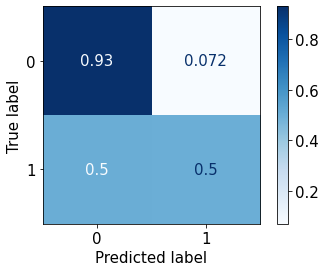

In [33]:
plot_confusion_matrix(estimator=best_svc, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

Видно, что модель хорошо определяет истинно отрицательные значения (>90%), но истинно положительные определяет со случайной вероятностью (~50%).

### Метод К ближайших соседей

Метод К ближайших соседей. Мы будем исследовать следующие гиперпараметры:
- число ближайших соседей (от 5 до 14);
- веса (одинаковые - uniform или пропорциональные обратному расстоянию от точки запроса - distance);

Обучим модель и переберём разные значения гиперпараметров в цикле.
При исследовании модели в лог будет выводиться техническая информация.

  0%|          | 0/2 [00:00<?, ?it/s]

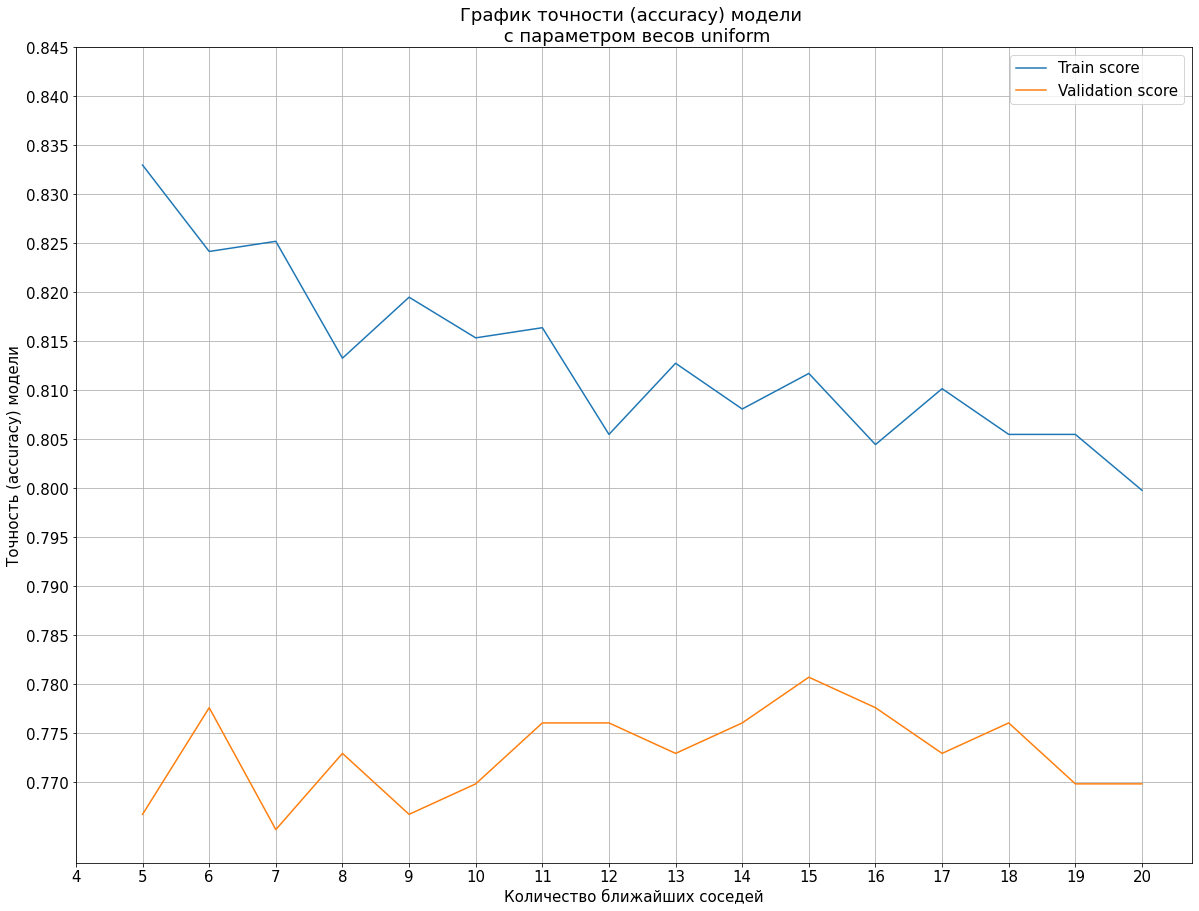

 50%|█████     | 1/2 [00:00<00:00,  1.09it/s]

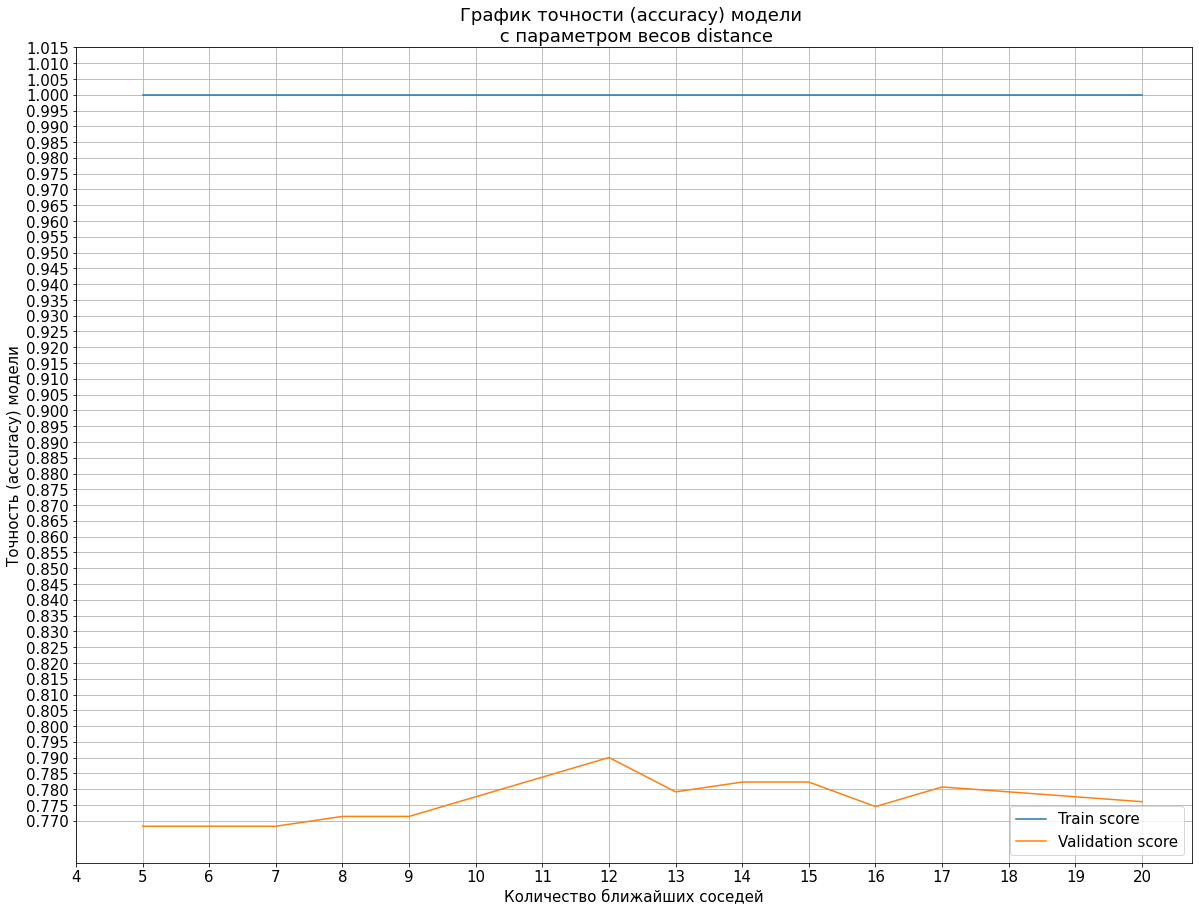

100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


In [34]:
best_knn = None
best_score = 0
best_weights = None
best_n_neighbors = 0

for weights in tqdm(['uniform', 'distance']):
    train_score_plt = []
    val_score_plt = []
    n_neighbors_plt = []
    for n_neighbors in range(5, 21):
        knn = KNeighborsClassifier(
            algorithm='auto',
            metric='minkowski',
            weights=weights,
            n_neighbors=n_neighbors
            )
        knn.fit(X_train, y_train)
        score = knn.score(X_val, y_val)
        train_score_plt.append(knn.score(X_train, y_train))
        val_score_plt.append(score)
        n_neighbors_plt.append(n_neighbors)
        #print(f'Accuracy: {score}')
        #print(f'Weights: {weights}, number of neighbors: {n_neighbors}')
        #print('-' * 37)
        if score > best_score:
                best_knn = knn
                best_score = score
                best_weights = weights
                best_n_neighbors = n_neighbors        
    
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(20,15))
    plt.plot(n_neighbors_plt, train_score_plt, label='Train score')
    plt.plot(n_neighbors_plt, val_score_plt, label='Validation score')
    plt.xticks(range(4,21))
    plt.yticks(np.arange(round(min(val_score_plt), 2), round(max(train_score_plt)+0.02, 2), 0.005))
    plt.xlabel('Количество ближайших соседей')
    plt.ylabel('Точность (accuracy) модели')
    plt.title(f'График точности (accuracy) модели \n с параметром весов {weights}')
    plt.grid(True)
    plt.legend()
    plt.show()

In [35]:
print(f'Лучшая модель K ближайших соседей показала долю правильных ответов {best_score}.')
print(f'Алгоритм весов: {best_weights}, число соседей: {best_n_neighbors}.')

Лучшая модель K ближайших соседей показала долю правильных ответов 0.7900466562986003.
Алгоритм весов: distance, число соседей: 12.


Мы получили удовлетворительную долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

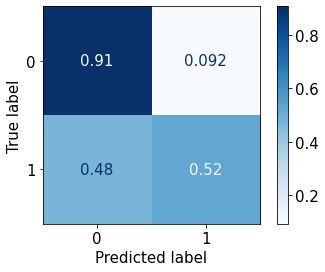

In [36]:
plot_confusion_matrix(estimator=best_knn, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

Видно, что модель хорошо определяет истинно отрицательные значения (90%), но истинно положительные определяет со случайной вероятностью (~50%).

### Многослойный перцептрон

Многослойный перцептрон. Мы будем исследовать следующие гиперпараметры:
- оптимизационный алгоритм (стохастический градиентный спуск и adam);
- архитектуру скрытых слоёв (1,2 или 3 слоя с количеством нейронов 50, 100-50 и 150-100-50);
- функцию активации (логистическая, гиперболический тангенс и ReLu);
- альфа для штрафа регуляризации l2 (0.0001, 0.001 и 0.01);
- скорость обучения (0.001, 0.01 и 0.1).

Обучим модель и переберём разные значения гиперпараметров с помощью поиска по решётке (GridSearchCV).


Поскольку GridSearchCV использует кросс-валидацию, объединим обучающую и валидационную выборку в одну новую - специально для перцептрона.

In [37]:
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])
print(X_cv.shape)
print(y_cv.shape)

(2571, 4)
(2571,)


In [38]:
%%time

parameter_space = {
    'hidden_layer_sizes' : [(50,), (100, 50,), (150, 100, 50,)],
    'solver' : ['sgd', 'adam'],
    'alpha' : [0.0001, 0.001, 0.01],
    'activation' : ['logistic', 'tanh', 'relu'],
    'learning_rate_init' : [0.001, 0.01, 0.1]
}

mlp = MLPClassifier(
    random_state=1337,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_grid = GridSearchCV(mlp, parameter_space, cv=5)
mlp_grid.fit(X_cv.values, y_cv.values)

CPU times: user 59min 11s, sys: 1min 17s, total: 1h 29s
Wall time: 7min 33s


GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True,
                                     learning_rate='adaptive', max_iter=500,
                                     random_state=1337),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100, 50),
                                                (150, 100, 50)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'solver': ['sgd', 'adam']})

In [39]:
best_mlp = mlp_grid.best_estimator_

In [40]:
print(f'Лучшая модель многослойного перцептрона показала долю правильных ответов {mlp_grid.best_score_}.')
print(f'Гиперпараметры: {mlp_grid.best_params_}')

Лучшая модель многослойного перцептрона показала долю правильных ответов 0.8024041403800386.
Гиперпараметры: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.1, 'solver': 'sgd'}


Мы получили хорошую долю правильных ответов. Чтобы лучше оценить модель, изучим матрицу ошибок:

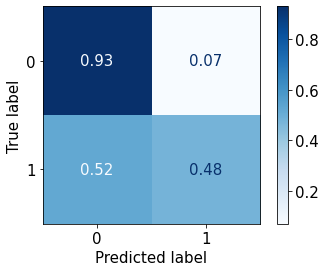

In [41]:
plot_confusion_matrix(estimator=best_mlp, X=X_val.values, y_true=y_val.values, normalize='true', cmap='Blues')
plt.show()

Видно, что модель хорошо определяет истинно отрицательные значения (90%), и определяет истинно положительные с точностью близкой к случайной (~50%). 

### Обоснование точности моделей

Во время исследования моделей, мы не получали долю правильных ответов выше 81,8% на валидационной выборке и долю истинно положительных ответов выше 61%. Почему так? 
Вероятно, модели не могут корректно предсказать метки объектов 0 и 1 из-за "скученности" данных.

Давайте оценим распределения признаков у объектов с разными метками с помощью kde-функции:

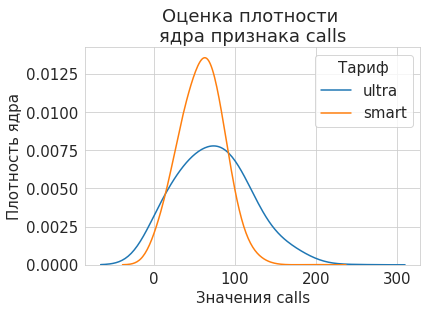

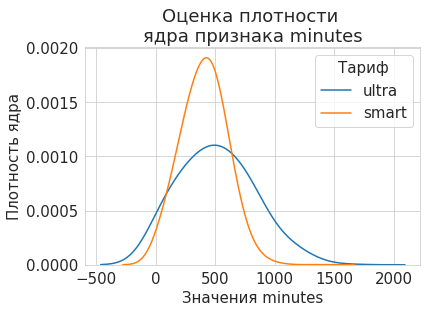

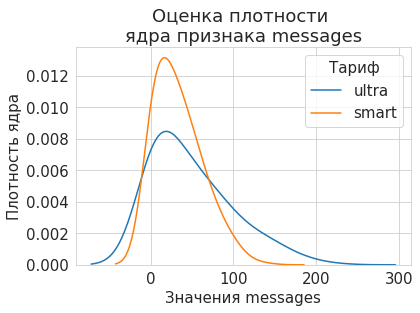

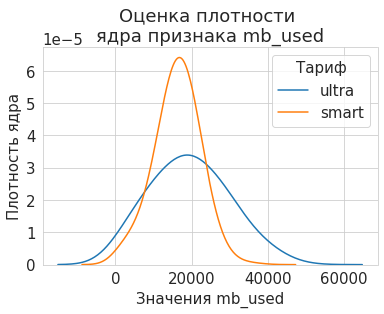

In [42]:
sns.set_style('whitegrid')
for col in ['calls', 'minutes', 'messages', 'mb_used']:
    sns.kdeplot(np.array(df[df['is_ultra'] == 1][col]), bw=0.5, label='ultra')
    sns.kdeplot(np.array(df[df['is_ultra'] == 0][col]), bw=0.5, label='smart')
    plt.title(f'Оценка плотности \nядра признака {col}')
    plt.xlabel(f'Значения {col}')
    plt.ylabel('Плотность ядра')
    plt.legend(title='Тариф')
    plt.show()

Как мы видим, распределения "наслаиваются" друг на друга, так что иногда просто невозможно определить, какая метка будет у объекта - 0 ("тариф smart") или 1 ("тариф ultra").

Что объясняет наши итоговые точности моделей на уровне 80% и доли истинно положительных ответов 60%.

---
**Вывод**: исследовав модели, мы получили наилучшие результаты с долей правильных ответов около 81% и долей истинно положительных ответов около 60% у моделей (50% у перцептрона);
- Случайный лес,
- Градиентный бустинг CatBoost,
- Многослойный перцептрон.

Также, мы исследовали исходные данные и поняли, что такие результаты точности моделей обусловлены характером исходных данных, а именно "скученностью" и наслаиванием распределений объектов с разными метками друг на друга.

## Проверьте модель на тестовой выборке

Мы выбираем модель CatBoost. Она показала хороший результат на валидационной выборке и имеет лучший компромисс между предсказанными долями истинно положительных и истинно отрицательных значений.

Обучим лучшую модель CatBoost на обучающей+валидационной выборке и подведём итоги на тестовой выборке.

Выборка train+val у нас уже готова - мы создали её во время обучения перцептрона.

In [43]:
best_cbc = CatBoostClassifier(
                iterations=2000,
                l2_leaf_reg=100,
                depth=6,
                logging_level='Silent',
                random_state=1337)
best_cbc.fit(X_cv, y_cv)

score = best_cbc.score(X_test, y_test)

print(f'На тестовом наборе данных лучшая модель CatBoost показала результат {score}')

На тестовом наборе данных лучшая модель CatBoost показала результат 0.8118195956454122


Мы получили хорошую долю правильных ответов. Взглянем на матрицу ошибок:

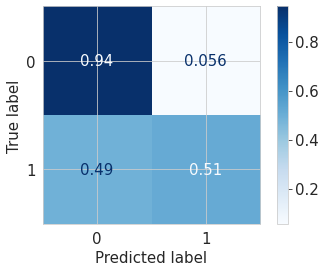

In [44]:
plot_confusion_matrix(estimator=best_cbc, X=X_test, y_true=y_test, normalize='true', cmap='Blues')
plt.show()

Что ж, модель отлично идентифицирует объекты с метками "0" и справляется с меткой "1" со случайной вероятностью.

---
**Вывод**: мы выбрали модель CatBoost и получили результат на тестовой выборке - 81,2% с долей истинно положительных 51%.

## (бонус) Проверьте модели на адекватность

Проверим наши модели на адекватность. Для этого обучим классификаторы-"пустышки" и выберем из них лучший.

In [45]:
strategies = ['most_frequent' , 'stratified' , 'uniform']
best_score = 0
best_strategy = None
best_dc = None

for s in strategies:
    dc = DummyClassifier(strategy=s, random_state=1337)
    dc.fit(X_train, y_train)
    score = dc.score(X_val, y_val)
    print(f'Accuracy: {score}')
    print(f'Strategy: {s}')
    print('-' * 37)
    if score > best_score:
        best_dc = dc
        best_strategy = s
        best_score = score

Accuracy: 0.6936236391912908
Strategy: most_frequent
-------------------------------------
Accuracy: 0.5583203732503889
Strategy: stratified
-------------------------------------
Accuracy: 0.5381026438569206
Strategy: uniform
-------------------------------------


In [46]:
print(f'Лучшая модель классификатора-пустышки показала долю правильных ответов {best_score}.')
print(f'Алгоритм пустышки: {best_strategy}.')

Лучшая модель классификатора-пустышки показала долю правильных ответов 0.6936236391912908.
Алгоритм пустышки: most_frequent.


Лучшую долю правильных ответов показал классификатор-пустышка, предсказывающий самую частую метку ("0") - 69,3%.

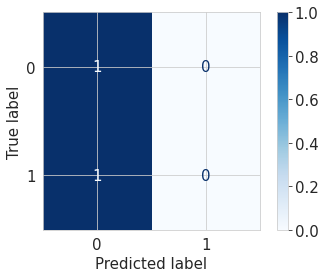

In [47]:
plot_confusion_matrix(estimator=best_dc, X=X_val, y_true=y_val, normalize='true', cmap='Blues')
plt.show()

In [48]:
print(f'На тестовом наборе данных модель пустышки показала результат {best_dc.score(X_test, y_test)}')

На тестовом наборе данных модель пустышки показала результат 0.6936236391912908


---
**Вывод**: все наши модели прошли проверку на адекватность, их результаты гораздо выше классификатора-"пустышки" с 69,3%.

## Общий вывод

Для построения системы, способной проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра» рекомендуется использовать модель CatBoost.

Модель даёт долю правильных ответов (accuracy) 81% на тестовом наборе данных.

В целом, в ходе проекта мы:

- в ходе этапа предобработки данных
    - выяснили, что данные уже подготовлены и очищены - не имеют пропусков и дубликатов;
    - произвели удаление выбросов, но поняли, что теряем слишком много данных и то, что нам представлялось выбросами - только характер данных; мы отказались от удаления выбросов;
    - проверили данные на мультиколлинеарность, обнаружили её для двух признаков - calls и minutes; и приняли решение оставить всё как есть, т.к. она не будет оказывать влияния на точность большинства наших моделей;
    
- в ходе этапа разбивки данных
    - мы произвели разбивку данных в соотношении 60%-20%-20% на обучающую-валидационную-тестовую выборку; мы сохранили исходное соотношение целевых меток в выборках;
    - мы осуществили стандартизацию данных, предупреждая утечку данных (обучили StandardScaler только на обучающей выборке и затем трансформировали все выборки по отдельности);
    
- в ходе этапа исследования моделей
    - мы получили наилучшие результаты с долей правильных ответов около 81% и долей истинно положительных ответов около 60% у моделей (50% у перцептрона): Случайный лес, Градиентный бустинг CatBoost, Многослойный перцептрон;
    - мы исследовали исходные данные и поняли, что такие результаты точности моделей обусловлены характером исходных данных, а именно "скученностью" и наслаиванием распределений объектов с разными метками друг на друга;

- в ходе тестирования модели
    - мы выбрали модель CatBoost и получили результат на тестовой выборке - 81,2% с долей истинно положительных 51%;
    
- все наши модели прошли проверку на адекватность, их результаты гораздо выше классификатора-"пустышки" с 69,3%.